## Absenteeism Analysis for HR Department

 ### Cyril Gebara and Tommaso Mercaldo, MBDS2
 
 ##### Outline
    - Libraries
    - Useful Functions
    - Data reading and preparation
    - Data cleaning and changing some variables
    - Dummificiation, Standardization and Baseline Model
    - Feature Engineering: Splitting and running a LM
    - Feature Selection: Chi-Squared and Information Gain
    - Embedded methods: Ridge and Lasso
    - Final Submission


###### Description of dataset
<https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work>

### Libraries

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

### Useful Functions




In [2]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation=45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def train_model(X,y, model, show_figures=True): 
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
    score = accuracy_score(y,y_pred)
    print("Accuracy = {0:.4f}".format(score))
    if show_figures:
        plot_confusion_matrix(conf_mat, y.unique())
        model.fit(X, y)
        get_feature_importance(model, X.columns, n_features=25)
    return model, score

def get_feature_importance(clf, features, n_features):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features)[sorted_idx], fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()

### Data Reading and preparation

    The dataset is offered in two separated fields, one for the training and another one for the test set. 

In [3]:
training = pd.read_csv("../Ass1/Absenteeism_at_work_classification_training.csv", delimiter=";", decimal=".")
test = pd.read_csv("../Ass1/Absenteeism_at_work_classification_test.csv", delimiter=";", decimal=".")

    To avoid applying the cleaning process two times (once for training and once for test), we joined both datasets. However, if we try to do join the two dataframes as they are, we will get an error because they do not have the same columns: `test` does not have a column for the target feature `Absenteeism`. Therefore, we first create this column in the test set and then we join the data.

In [4]:
test['Absenteeism'] = 0
dataset = training.append(test)

    Let's now visualize the dataset to see where to begin.

In [5]:
pd.options.display.max_columns = dataset.shape[1] # It prints the info in all the columns

dataset.describe()

ID  Reason.for.absence  Month.of.absence  Day.of.the.week  \
count  740.000000          740.000000        740.000000       740.000000   
mean   370.500000           19.216216          6.324324         3.914865   
std    213.763888            8.433406          3.436287         1.421675   
min      1.000000            0.000000          0.000000         2.000000   
25%    185.750000           13.000000          3.000000         3.000000   
50%    370.500000           23.000000          6.000000         4.000000   
75%    555.250000           26.000000          9.000000         5.000000   
max    740.000000           28.000000         12.000000         6.000000   

          Seasons  Transportation.expense  Distance.from.Residence.to.Work  \
count  740.000000              740.000000                       740.000000   
mean     2.544595              221.329730                        29.631081   
std      1.111831               66.952223                        14.836788   
min      1.000000              118.000000                         5.000000   
25%      2.000000              179.000000                        16.000000   
50%      3.000000              225.000000                        26.000000   
75%      4.000000              260.000000                        50.000000   
max      4.000000              388.000000                        52.000000   

       Service.time         Age  Work.load.Average.day  Hit.target  \
count    740.000000  740.000000             740.000000  740.000000   
mean      12.554054   36.450000             271.490235   94.587838   
std        4.384873    6.478772              39.058116    3.779313   
min        1.000000   27.000000             205.917000   81.000000   
25%        9.000000   31.000000             244.387000   93.000000   
50%       13.000000   37.000000             264.249000   95.000000   
75%       16.000000   40.000000             294.217000   97.000000   
max       29.000000   58.000000             378.884000  100.000000   

       Disciplinary.failure   Education         Son  Social.drinker  \
count            740.000000  740.000000  740.000000      740.000000   
mean               0.054054    1.291892    1.018919        0.567568   
std                0.226277    0.673238    1.098489        0.495749   
min                0.000000    1.000000    0.000000        0.000000   
25%                0.000000    1.000000    0.000000        0.000000   
50%                0.000000    1.000000    1.000000        1.000000   
75%                0.000000    1.000000    2.000000        1.000000   
max                1.000000    4.000000    4.000000        1.000000   

       Social.smoker         Pet      Weight      Height  Body.mass.index  \
count     740.000000  740.000000  740.000000  740.000000       740.000000   
mean        0.072973    0.745946   79.035135  172.114865        26.677027   
std         0.260268    1.318258   12.883211    6.034995         4.285452   
min         0.000000    0.000000   56.000000  163.000000        19.000000   
25%         0.000000    0.000000   69.000000  169.000000        24.000000   
50%         0.000000    0.000000   83.000000  170.000000        25.000000   
75%         0.000000    1.000000   89.000000  172.000000        31.000000   
max         1.000000    8.000000  108.000000  196.000000        38.000000   

        ID.Worker  Absenteeism  
count  740.000000   740.000000  
mean    18.017568     0.294595  
std     11.021247     0.456169  
min      1.000000     0.000000  
25%      9.000000     0.000000  
50%     18.000000     0.000000  
75%     28.000000     1.000000  
max     36.000000     1.000000

    We can see a problem by just taking a look to the summary: there are some categorical columns codified as numeric (including the target feature `Absenteeism`). In addition, I will recommend you to take a deeper look to the data to detect more subtle issues: correlation between features, skewness in the feature values...


In [6]:
dataset.isnull().sum()

ID                                 0
Reason.for.absence                 0
Month.of.absence                   0
Day.of.the.week                    0
Seasons                            0
Transportation.expense             0
Distance.from.Residence.to.Work    0
Service.time                       0
Age                                0
Work.load.Average.day              0
Hit.target                         0
Disciplinary.failure               0
Education                          0
Son                                0
Social.drinker                     0
Social.smoker                      0
Pet                                0
Weight                             0
Height                             0
Body.mass.index                    0
ID.Worker                          0
Absenteeism                        0
dtype: int64

### Data Cleaning
    Checking for Nulls

In [7]:
dataset.isnull().sum()

ID                                 0
Reason.for.absence                 0
Month.of.absence                   0
Day.of.the.week                    0
Seasons                            0
Transportation.expense             0
Distance.from.Residence.to.Work    0
Service.time                       0
Age                                0
Work.load.Average.day              0
Hit.target                         0
Disciplinary.failure               0
Education                          0
Son                                0
Social.drinker                     0
Social.smoker                      0
Pet                                0
Weight                             0
Height                             0
Body.mass.index                    0
ID.Worker                          0
Absenteeism                        0
dtype: int64

In [8]:
dataset.dtypes

ID                                   int64
Reason.for.absence                   int64
Month.of.absence                     int64
Day.of.the.week                      int64
Seasons                              int64
Transportation.expense               int64
Distance.from.Residence.to.Work      int64
Service.time                         int64
Age                                  int64
Work.load.Average.day              float64
Hit.target                           int64
Disciplinary.failure                 int64
Education                            int64
Son                                  int64
Social.drinker                       int64
Social.smoker                        int64
Pet                                  int64
Weight                               int64
Height                               int64
Body.mass.index                      int64
ID.Worker                            int64
Absenteeism                          int64
dtype: object

The dataset does not have any null values. We can continue with our cleaning by first converting some numerical variables to categorical.

In [9]:
categorical_columns = ['ID', 'ID.Worker','Reason.for.absence', 'Month.of.absence', 'Day.of.the.week', 'Seasons', 'Disciplinary.failure', 'Social.drinker', 'Social.smoker', 'Absenteeism']

dataset[categorical_columns] = dataset[categorical_columns].astype("category")
dataset.dtypes

ID                                 category
Reason.for.absence                 category
Month.of.absence                   category
Day.of.the.week                    category
Seasons                            category
Transportation.expense                int64
Distance.from.Residence.to.Work       int64
Service.time                          int64
Age                                   int64
Work.load.Average.day               float64
Hit.target                            int64
Disciplinary.failure               category
Education                             int64
Son                                   int64
Social.drinker                     category
Social.smoker                      category
Pet                                   int64
Weight                                int64
Height                                int64
Body.mass.index                       int64
ID.Worker                          category
Absenteeism                        category
dtype: object

## Cleaning and Changing some variables
    To facilitate the understanding of the feature analysis, we change the name of some of them to their actual meaning (link in dataset description file).
    Moreover, we decided to bin some variables like Age, Transportation Expense and Distance from residency to mitigate the bias in our analysis. We first tried to bin them using categorical and not integer as in for Age: young, mid age and old instead of 1,2,3 but we got a lower accuracy in our later models. Same for the other two mentioned before.
    
    We tried binning the Reasons for Absence into 3,4 and 5 different groups but out accuracy was dropping a lot, so we diregarded this step.
  

In [10]:
reason_for_absence_dict={0:'Infectious parasitic diseases',
                         1:'Neoplasms',
                         2:'Diseases of the blood',
                         3:'Endocrine and metabolic diseases',
                         4:'Mental and behavioural disorders',
                         5:'Diseases of the nervous system',
                         6:'Diseases of the eye and adnexa',
                         7:'Diseases of the ear and mastoid process',
                         8:'Diseases of the circulatory system',
                         9:'Diseases of the respiratory system',
                         10:'Diseases of the digestive system',
                         11:'Diseases of the skin and subcutaneous tissue',
                         12:'Diseases of the musculoskeletal system and connective tissue', 
                         13:'Diseases of the genitourinary system',
                         14:'Pregnancy, childbirth and the puerperium',
                         15:'Certain conditions originating in the perinatal',
                         16:'Congenital malformations, deformations and chromosomal abnormalities',
                         17:'Symptoms, signs and abnormal clinical  findings',
                         18:'Injury, poisoning and certain other consequences of external causes',
                         19:'causes of morbidity and mortality',
                         21:'Factors influencing health status and contact with health services',
                         22:'patient follow-up',
                         23:'medical consultation',
                         24:'blood donation',
                         25:'laboratory examination',
                         26:'unjustified absence',
                         27:'physiotherapy',
                         28:'dental consultation'}

dataset['Reason.for.absence'] = dataset['Reason.for.absence'].replace(reason_for_absence_dict).astype('category')

dataset.Seasons = dataset.Seasons.replace({1:'summer',2:'autumn',3:'winter',4:'spring'}).astype('category')

dataset['Age'] = pd.cut(x=dataset['Age'], bins=[25,35,45,100], labels=[1,2,3]).astype('int64')

dataset['Transportation.expense'] = pd.cut(x=dataset['Transportation.expense'], bins=[100,200,300,400], labels=[1, 2, 3]).astype('int64')

dataset['Distance.from.Residence.to.Work'] = pd.cut(x=dataset['Distance.from.Residence.to.Work'], bins=[0,15,35,55], labels=[1, 2, 3]).astype('int64')

dataset.Education = dataset.Education.replace({1:'highschool',2:'graduate',3:'postgraduate',4:'master&PhD'}).astype('category')


In [11]:
dataset.dtypes

ID                                 category
Reason.for.absence                 category
Month.of.absence                   category
Day.of.the.week                    category
Seasons                            category
Transportation.expense                int64
Distance.from.Residence.to.Work       int64
Service.time                          int64
Age                                   int64
Work.load.Average.day               float64
Hit.target                            int64
Disciplinary.failure               category
Education                          category
Son                                   int64
Social.drinker                     category
Social.smoker                      category
Pet                                   int64
Weight                                int64
Height                                int64
Body.mass.index                       int64
ID.Worker                          category
Absenteeism                        category
dtype: object

## Dummification, Standardization and Baseline model

    In order to have a baseline to compare the improvements introduced by the feature engineering process we will train a model with the dataset as it is.
    Finally, since we have numerical and categorical values, we have to dummify the categorical features in the dataset so we can train our ML models. We will also standardize the numerical values
    We decided not to include the binary variables neither in dummification nor in the standardization. We the add them back to our dummified_dataset
       

In [12]:
                              
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

categorical_cols = dataset.columns[dataset.dtypes=='category'].tolist()
categorical_cols.remove('Absenteeism') # Remove the target variable
categorical_cols.remove('Social.smoker')
categorical_cols.remove('Social.drinker')
categorical_cols.remove('Disciplinary.failure')


# I do not want to include the ID or the ID of the worker
categorical_cols.remove('ID') 
categorical_cols.remove('ID.Worker')
numerical_cols = dataset.columns[dataset.dtypes!='category'].tolist()

ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

# Concat the numerical and dummified categorical columns
dummified_dataset = pd.concat([pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(dataset[numerical_cols])), columns=numerical_cols).reset_index(drop=True),                    
                               pd.DataFrame(ohe.fit_transform(dataset[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True),
                               dataset['Social.smoker'].reset_index(drop=True),dataset['Social.drinker'].reset_index(drop=True),dataset['Disciplinary.failure'].reset_index(drop=True), 
                               dataset['Absenteeism'].reset_index(drop=True)], axis=1)

dummified_dataset



Transportation.expense  Distance.from.Residence.to.Work  Service.time  \
0                       0.5                              1.0      0.428571   
1                       0.0                              0.0      0.607143   
2                       0.0                              1.0      0.607143   
3                       0.5                              0.0      0.464286   
4                       0.5                              1.0      0.428571   
..                      ...                              ...           ...   
735                     0.5                              1.0      0.000000   
736                     0.0                              0.0      0.321429   
737                     0.0                              0.0      0.321429   
738                     1.0                              1.0      0.071429   
739                     0.0                              0.0      0.428571   

     Age  Work.load.Average.day  Hit.target   Son    Pet    Weight    Height  \
0    0.0               0.194471    0.842105  0.50  0.125  0.653846  0.272727   
1    1.0               0.194471    0.842105  0.25  0.000  0.807692  0.454545   
2    0.5               0.194471    0.842105  0.00  0.000  0.634615  0.212121   
3    0.5               0.194471    0.842105  0.50  0.000  0.230769  0.151515   
4    0.0               0.194471    0.842105  0.50  0.125  0.653846  0.272727   
..   ...                    ...         ...   ...    ...       ...       ...   
735  0.0               0.339296    0.631579  0.25  1.000  0.230769  0.454545   
736  0.5               0.339296    0.631579  0.00  0.000  0.519231  0.272727   
737  0.5               0.339296    0.631579  0.00  0.000  0.519231  0.272727   
738  0.0               0.339296    0.631579  0.25  0.500  0.461538  0.272727   
739  0.5               0.377540    0.736842  0.25  1.000  0.807692  0.212121   

     Body.mass.index  ...  Seasons_spring  Seasons_summer  Seasons_winter  \
0           0.578947  ...             0.0             1.0             0.0   
1           0.631579  ...             0.0             1.0             0.0   
2           0.631579  ...             0.0             1.0             0.0   
3           0.263158  ...             0.0             1.0             0.0   
4           0.578947  ...             0.0             1.0             0.0   
..               ...  ...             ...             ...             ...   
735         0.105263  ...             0.0             1.0             0.0   
736         0.473684  ...             0.0             1.0             0.0   
737         0.473684  ...             0.0             1.0             0.0   
738         0.421053  ...             0.0             1.0             0.0   
739         0.789474  ...             0.0             1.0             0.0   

     Education_graduate  Education_highschool  Education_master&PhD  \
0                   0.0                   1.0                   0.0   
1                   0.0                   1.0                   0.0   
2                   0.0                   1.0                   0.0   
3                   0.0                   1.0                   0.0   
4                   0.0                   1.0                   0.0   
..                  ...                   ...                   ...   
735                 1.0                   0.0                   0.0   
736                 0.0                   1.0                   0.0   
737                 0.0                   1.0                   0.0   
738                 0.0                   1.0                   0.0   
739                 0.0                   1.0                   0.0   

     Education_postgraduate  Social.smoker  Social.drinker  \
0                       0.0              0               1   
1                       0.0              0               1   
2                       0.0              0               1   
3                       0.0              1               1   
4                  

In [13]:
dummified_dataset['Disciplinary.failure'] = dummified_dataset['Disciplinary.failure'].astype('int64') 
dummified_dataset['Social.drinker'] = dummified_dataset['Social.drinker'].astype('int64') 
dummified_dataset['Social.smoker'] = dummified_dataset['Social.smoker'].astype('int64') 

In [14]:

dummified_dataset.dtypes

Transportation.expense              float64
Distance.from.Residence.to.Work     float64
Service.time                        float64
Age                                 float64
Work.load.Average.day               float64
                                     ...   
Education_postgraduate              float64
Social.smoker                         int64
Social.drinker                        int64
Disciplinary.failure                  int64
Absenteeism                        category
Length: 69, dtype: object

Accuracy = 0.8078


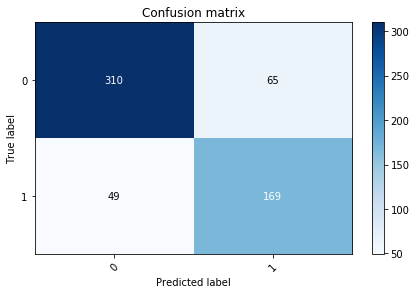

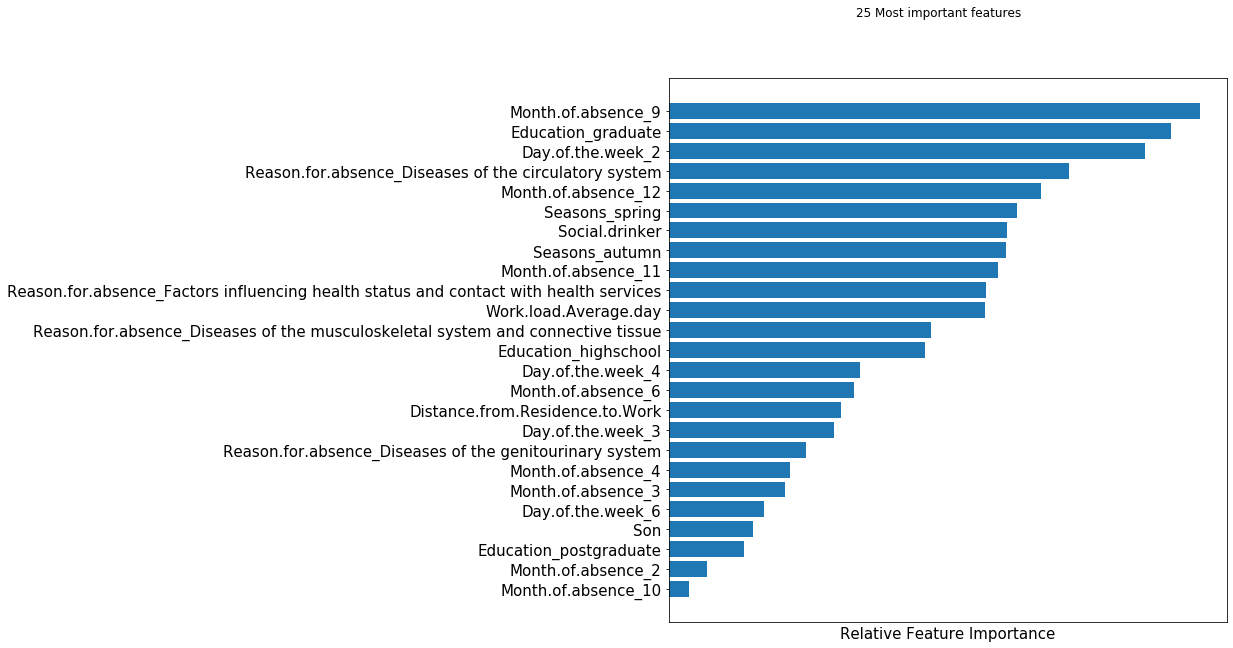

In [15]:
baseline_model, score = train_model(dummified_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), dummified_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, penalty='none'))

    Accuracy around 81%. Not a bad start. For sure the model can be improved after removing some outliers and misleading variables. The baseline Let's see if we can improve it. To that end, we can study the  most important features in this baseline model. This will give us a first idea on the most important aspects in order to predict the `Absenteeism`.
    Moreover, we can notice that Reson.for.absence is one of the most important features affecting Abseenteeism which is obvious since absence is caused by a serious illness which will lead to an employee to be absent more often.

### Outliers

We decided to resplit our dummified dataset into train and test since if we remove the outliers from both we will not be able to "resplit" our dataset in a correct way. As in we will include the Absenteeism column of the test set which is full of zeros which will mislead our predictions since they are not the correct values as a target. 
The test set will be kept the same and be used for the final predictions. We will use only our train set since we have the correct target values of Absenteeism.

To check number of outliers

In [16]:
dummified_dataset_train = dummified_dataset.iloc[0:593]
dummified_dataset_test = dummified_dataset.iloc[593:740]

In [17]:
dummified_dataset_test

Transportation.expense  Distance.from.Residence.to.Work  Service.time  \
593                     0.0                              1.0      0.607143   
594                     0.5                              1.0      0.357143   
595                     0.5                              0.5      0.535714   
596                     0.0                              1.0      0.607143   
597                     1.0                              0.5      0.107143   
..                      ...                              ...           ...   
735                     0.5                              1.0      0.000000   
736                     0.0                              0.0      0.321429   
737                     0.0                              0.0      0.321429   
738                     1.0                              1.0      0.071429   
739                     0.0                              0.0      0.428571   

     Age  Work.load.Average.day  Hit.target   Son  Pet    Weight    Height  \
593  0.5               0.194471    0.842105  0.00  0.0  0.634615  0.212121   
594  0.5               0.194471    0.842105  1.00  0.0  0.173077  0.151515   
595  0.5               0.194471    0.842105  0.00  0.0  0.211538  0.212121   
596  0.5               0.194471    0.842105  0.00  0.0  0.634615  0.212121   
597  0.0               0.000000    0.578947  0.00  0.0  0.538462  0.575758   
..   ...                    ...         ...   ...  ...       ...       ...   
735  0.0               0.339296    0.631579  0.25  1.0  0.230769  0.454545   
736  0.5               0.339296    0.631579  0.00  0.0  0.519231  0.272727   
737  0.5               0.339296    0.631579  0.00  0.0  0.519231  0.272727   
738  0.0               0.339296    0.631579  0.25  0.5  0.461538  0.272727   
739  0.5               0.377540    0.736842  0.25  1.0  0.807692  0.212121   

     Body.mass.index  ...  Seasons_spring  Seasons_summer  Seasons_winter  \
593         0.631579  ...             0.0             1.0             0.0   
594         0.210526  ...             0.0             1.0             0.0   
595         0.210526  ...             0.0             1.0             0.0   
596         0.631579  ...             0.0             1.0             0.0   
597         0.315789  ...             0.0             1.0             0.0   
..               ...  ...             ...             ...             ...   
735         0.105263  ...             0.0             1.0             0.0   
736         0.473684  ...             0.0             1.0             0.0   
737         0.473684  ...             0.0             1.0             0.0   
738         0.421053  ...             0.0             1.0             0.0   
739         0.789474  ...             0.0             1.0             0.0   

     Education_graduate  Education_highschool  Education_master&PhD  \
593                 0.0                   1.0                   0.0   
594                 0.0                   1.0                   0.0   
595                 0.0                   1.0                   0.0   
596                 0.0                   1.0                   0.0   
597                 1.0                   0.0                   0.0   
..                  ...                   ...                   ...   
735                 1.0                   0.0                   0.0   
736                 0.0                   1.0                   0.0   
737                 0.0                   1.0                   0.0   
738                 0.0                   1.0                   0.0   
739                 0.0                   1.0                   0.0   

     Education_postgraduate  Social.smoker  Social.drinker  \
593                     0.0              0               1   
594                     0.0              0               1   
595                     0.0              0               1   
596                     0.0              0               1   
597                     0.0              0 

    We tried checking for outliers subtracting 1.5, 2, 2.5, 3 and found that 1.5 is the most optimal one

In [18]:
Q1 = dummified_dataset_train[numerical_cols].quantile(0.25)
Q3 = dummified_dataset_train[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

In [19]:
((dummified_dataset_train[numerical_cols] < (Q1 - 1.5 * IQR)) | (dummified_dataset_train[numerical_cols] > (Q3 + 1.5 * IQR))).sum()


Transportation.expense              0
Distance.from.Residence.to.Work     0
Service.time                        5
Age                                 0
Work.load.Average.day              27
Hit.target                         16
Son                                 0
Pet                                32
Weight                              0
Height                             86
Body.mass.index                     0
dtype: int64

    We decided to remove Height and Weight since they are already included in Body Mass Index and since Height has many outliers compared to BMI which has none. And since we split our data, we have to remove them from both the test and train.
    Moreover, we tried removing Education since most of the employees that get absent have a highschool degree in our dataset, we got a lower accuracy so we disregarded this step.

In [20]:
dummified_dataset_train = dummified_dataset_train.drop('Height', axis=1)
dummified_dataset_train = dummified_dataset_train.drop('Weight', axis=1)
dummified_dataset_test = dummified_dataset_test.drop('Height', axis=1)
dummified_dataset_test = dummified_dataset_test.drop('Weight', axis=1)
numerical_cols.remove('Height')
numerical_cols.remove('Weight')


In [21]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

In [22]:
dummified_dataset_train

Transportation.expense  Distance.from.Residence.to.Work  Service.time  \
0                       0.5                              1.0      0.428571   
1                       0.0                              0.0      0.607143   
2                       0.0                              1.0      0.607143   
3                       0.5                              0.0      0.464286   
4                       0.5                              1.0      0.428571   
..                      ...                              ...           ...   
588                     1.0                              0.5      0.392857   
589                     0.5                              1.0      0.428571   
590                     0.5                              0.0      0.464286   
591                     0.5                              0.5      0.464286   
592                     0.0                              1.0      0.464286   

     Age  Work.load.Average.day  Hit.target   Son    Pet  Body.mass.index  \
0    0.0               0.194471    0.842105  0.50  0.125         0.578947   
1    1.0               0.194471    0.842105  0.25  0.000         0.631579   
2    0.5               0.194471    0.842105  0.00  0.000         0.631579   
3    0.5               0.194471    0.842105  0.50  0.000         0.263158   
4    0.0               0.194471    0.842105  0.50  0.125         0.578947   
..   ...                    ...         ...   ...    ...              ...   
588  0.0               0.339296    0.631579  0.75  0.000         0.315789   
589  0.0               0.339296    0.631579  0.50  0.125         0.578947   
590  0.5               0.339296    0.631579  0.25  0.125         0.526316   
591  0.5               0.377540    0.736842  0.50  0.250         0.842105   
592  1.0               0.377540    0.736842  0.25  0.125         0.315789   

     Reason.for.absence_Certain conditions originating in the perinatal  \
0                                                  0.0                    
1                                                  0.0                    
2                                                  0.0                    
3                                                  0.0                    
4                                                  0.0                    
..                                                 ...                    
588                                                0.0                    
589                                                0.0                    
590                                                0.0                    
591                                                0.0                    
592                                                0.0                    

     Reason.for.absence_Congenital malformations, deformations and chromosomal abnormalities  \
0                                                  0.0                                         
1                                                  0.0                                         
2                                                  0.0                                         
3                                                  0.0                                         
4                                                  0.0                                         
..                                                 ...                                         
588                                                0.0                                         
589                                                0.0                                         
590                                                0.0                                         
591                                                0.0                                         
592                                                0.0                                         

     ...  Seasons_spring  Seasons_summer  Seasons_winter  Education_graduate  \
0    ... 

Analyzing outliers of column: Transportation.expense
0 outliers removed


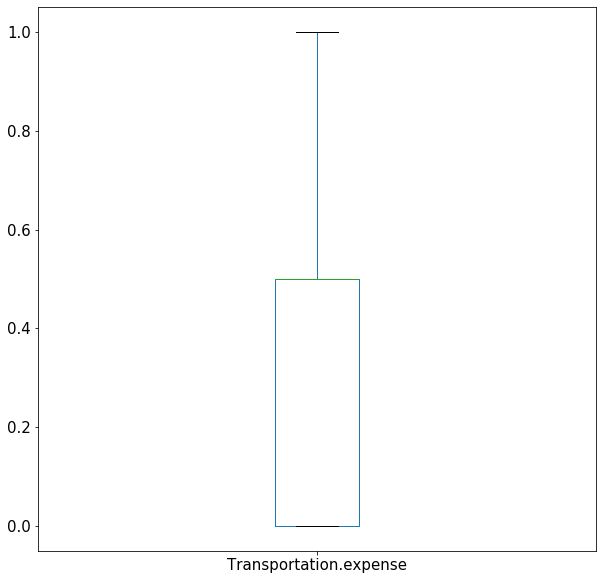

Analyzing outliers of column: Distance.from.Residence.to.Work
0 outliers removed


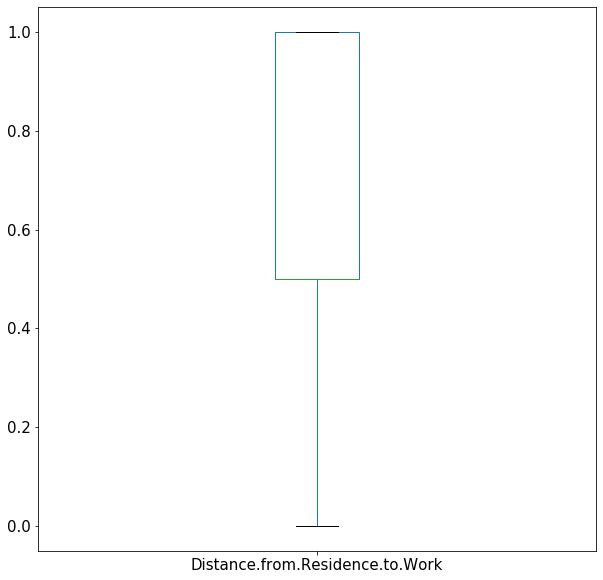

Analyzing outliers of column: Service.time
5 outliers removed


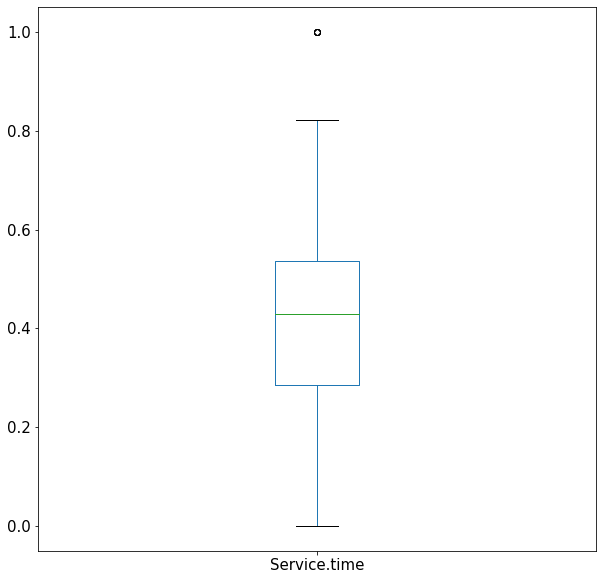

Analyzing outliers of column: Age
0 outliers removed


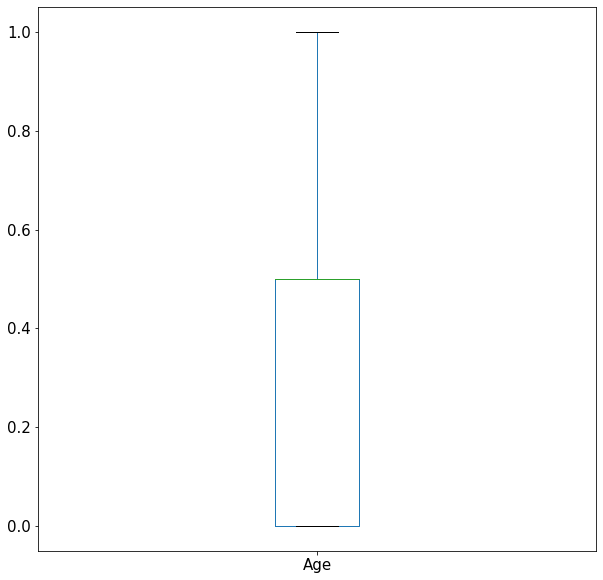

Analyzing outliers of column: Work.load.Average.day
26 outliers removed


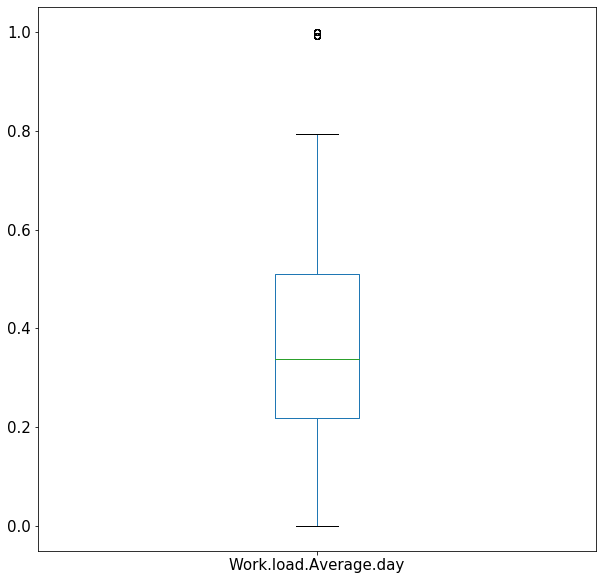

Analyzing outliers of column: Hit.target
16 outliers removed


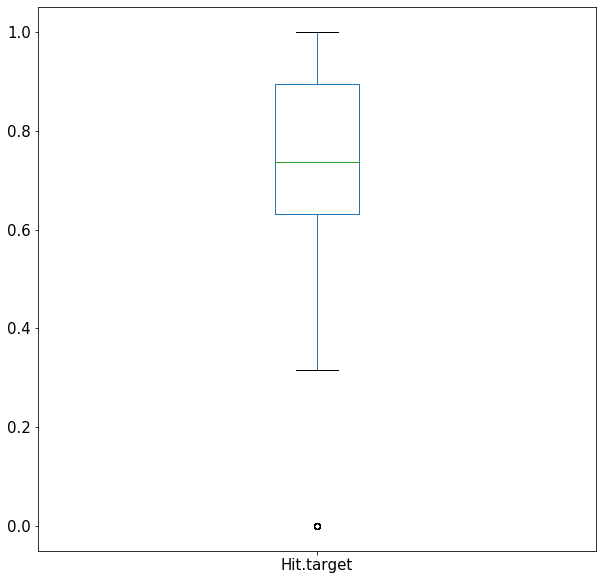

Analyzing outliers of column: Son
0 outliers removed


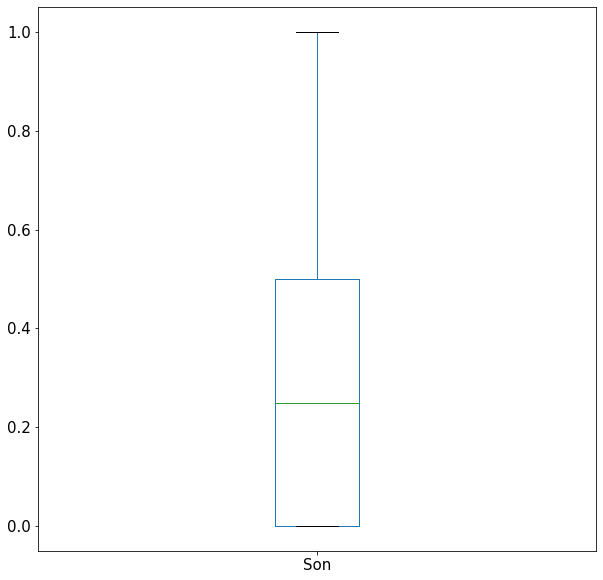

Analyzing outliers of column: Pet
28 outliers removed


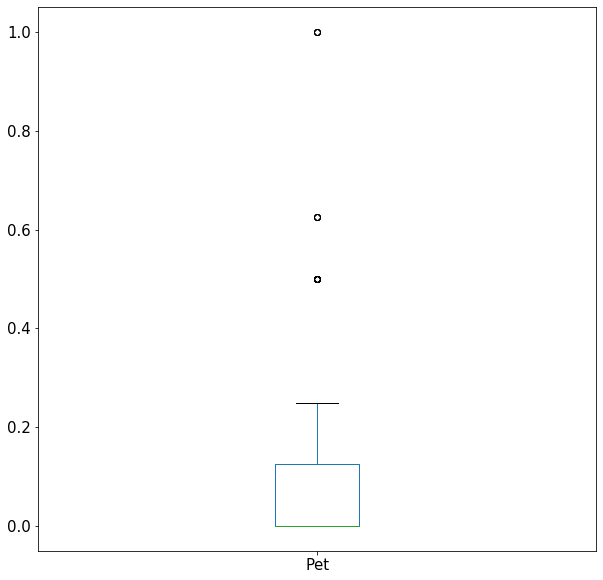

Analyzing outliers of column: Body.mass.index
0 outliers removed


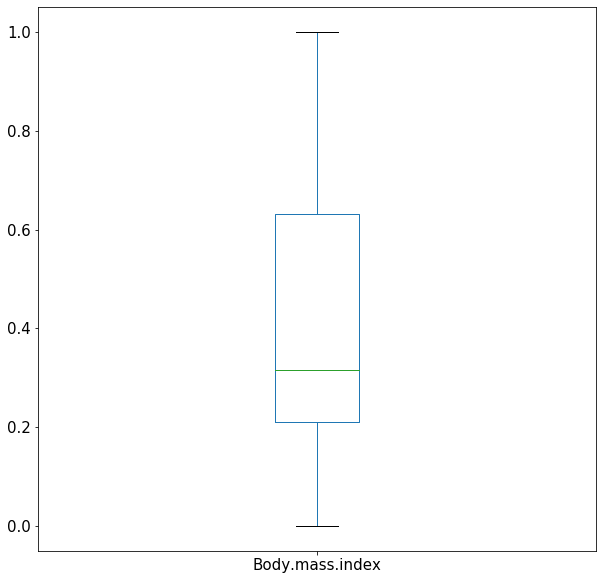

In [23]:
for (columnName, _) in dummified_dataset_train[numerical_cols].iteritems():
        print("Analyzing outliers of column: {}".format(columnName))
        plt.figure(figsize=(10,10))
        dummified_dataset_train.boxplot([columnName], grid=False, fontsize=15)
        dummified_dataset_train = remove_outlier(dummified_dataset_train,columnName)
        plt.show()

Number of rows let from our 596 train dataset. This means that we removed 78.

In [24]:
len(dummified_dataset_train)

518

In [25]:
dummified_dataset_test.drop('Absenteeism',axis = 1)

Transportation.expense  Distance.from.Residence.to.Work  Service.time  \
593                     0.0                              1.0      0.607143   
594                     0.5                              1.0      0.357143   
595                     0.5                              0.5      0.535714   
596                     0.0                              1.0      0.607143   
597                     1.0                              0.5      0.107143   
..                      ...                              ...           ...   
735                     0.5                              1.0      0.000000   
736                     0.0                              0.0      0.321429   
737                     0.0                              0.0      0.321429   
738                     1.0                              1.0      0.071429   
739                     0.0                              0.0      0.428571   

     Age  Work.load.Average.day  Hit.target   Son  Pet  Body.mass.index  \
593  0.5               0.194471    0.842105  0.00  0.0         0.631579   
594  0.5               0.194471    0.842105  1.00  0.0         0.210526   
595  0.5               0.194471    0.842105  0.00  0.0         0.210526   
596  0.5               0.194471    0.842105  0.00  0.0         0.631579   
597  0.0               0.000000    0.578947  0.00  0.0         0.315789   
..   ...                    ...         ...   ...  ...              ...   
735  0.0               0.339296    0.631579  0.25  1.0         0.105263   
736  0.5               0.339296    0.631579  0.00  0.0         0.473684   
737  0.5               0.339296    0.631579  0.00  0.0         0.473684   
738  0.0               0.339296    0.631579  0.25  0.5         0.421053   
739  0.5               0.377540    0.736842  0.25  1.0         0.789474   

     Reason.for.absence_Certain conditions originating in the perinatal  \
593                                                0.0                    
594                                                0.0                    
595                                                0.0                    
596                                                0.0                    
597                                                0.0                    
..                                                 ...                    
735                                                0.0                    
736                                                0.0                    
737                                                0.0                    
738                                                0.0                    
739                                                0.0                    

     Reason.for.absence_Congenital malformations, deformations and chromosomal abnormalities  \
593                                                0.0                                         
594                                                0.0                                         
595                                                0.0                                         
596                                                0.0                                         
597                                                0.0                                         
..                                                 ...                                         
735                                                0.0                                         
736                                                0.0                                         
737                                                0.0                                         
738                                                0.0                                         
739                                                0.0                                         

     ...  Seasons_autumn  Seasons_spring  Seasons_summer  Seasons_winter  \
593  ...             0.0             

## Feature Engineering

   ### Splitting the data
   As explained before, we will not be working with the test set. Below we can see that the only dataset we used is the train one since it has the correct target values of Absenteenism.


In [26]:
from sklearn.model_selection import train_test_split

X = dummified_dataset_train.drop(['Absenteeism'],axis=1)
y = dummified_dataset_train['Absenteeism']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


### Linear Model
We decided to run this model again after splitting the training set to compare with our baseline model done before our finidings in the confusion matrix explained below

In [27]:
initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
initial_lm_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
def get_feature_importance(clf):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(30,30))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=16)
    featax.set_xlabel('Relative Feature Importance', fontsize=20)

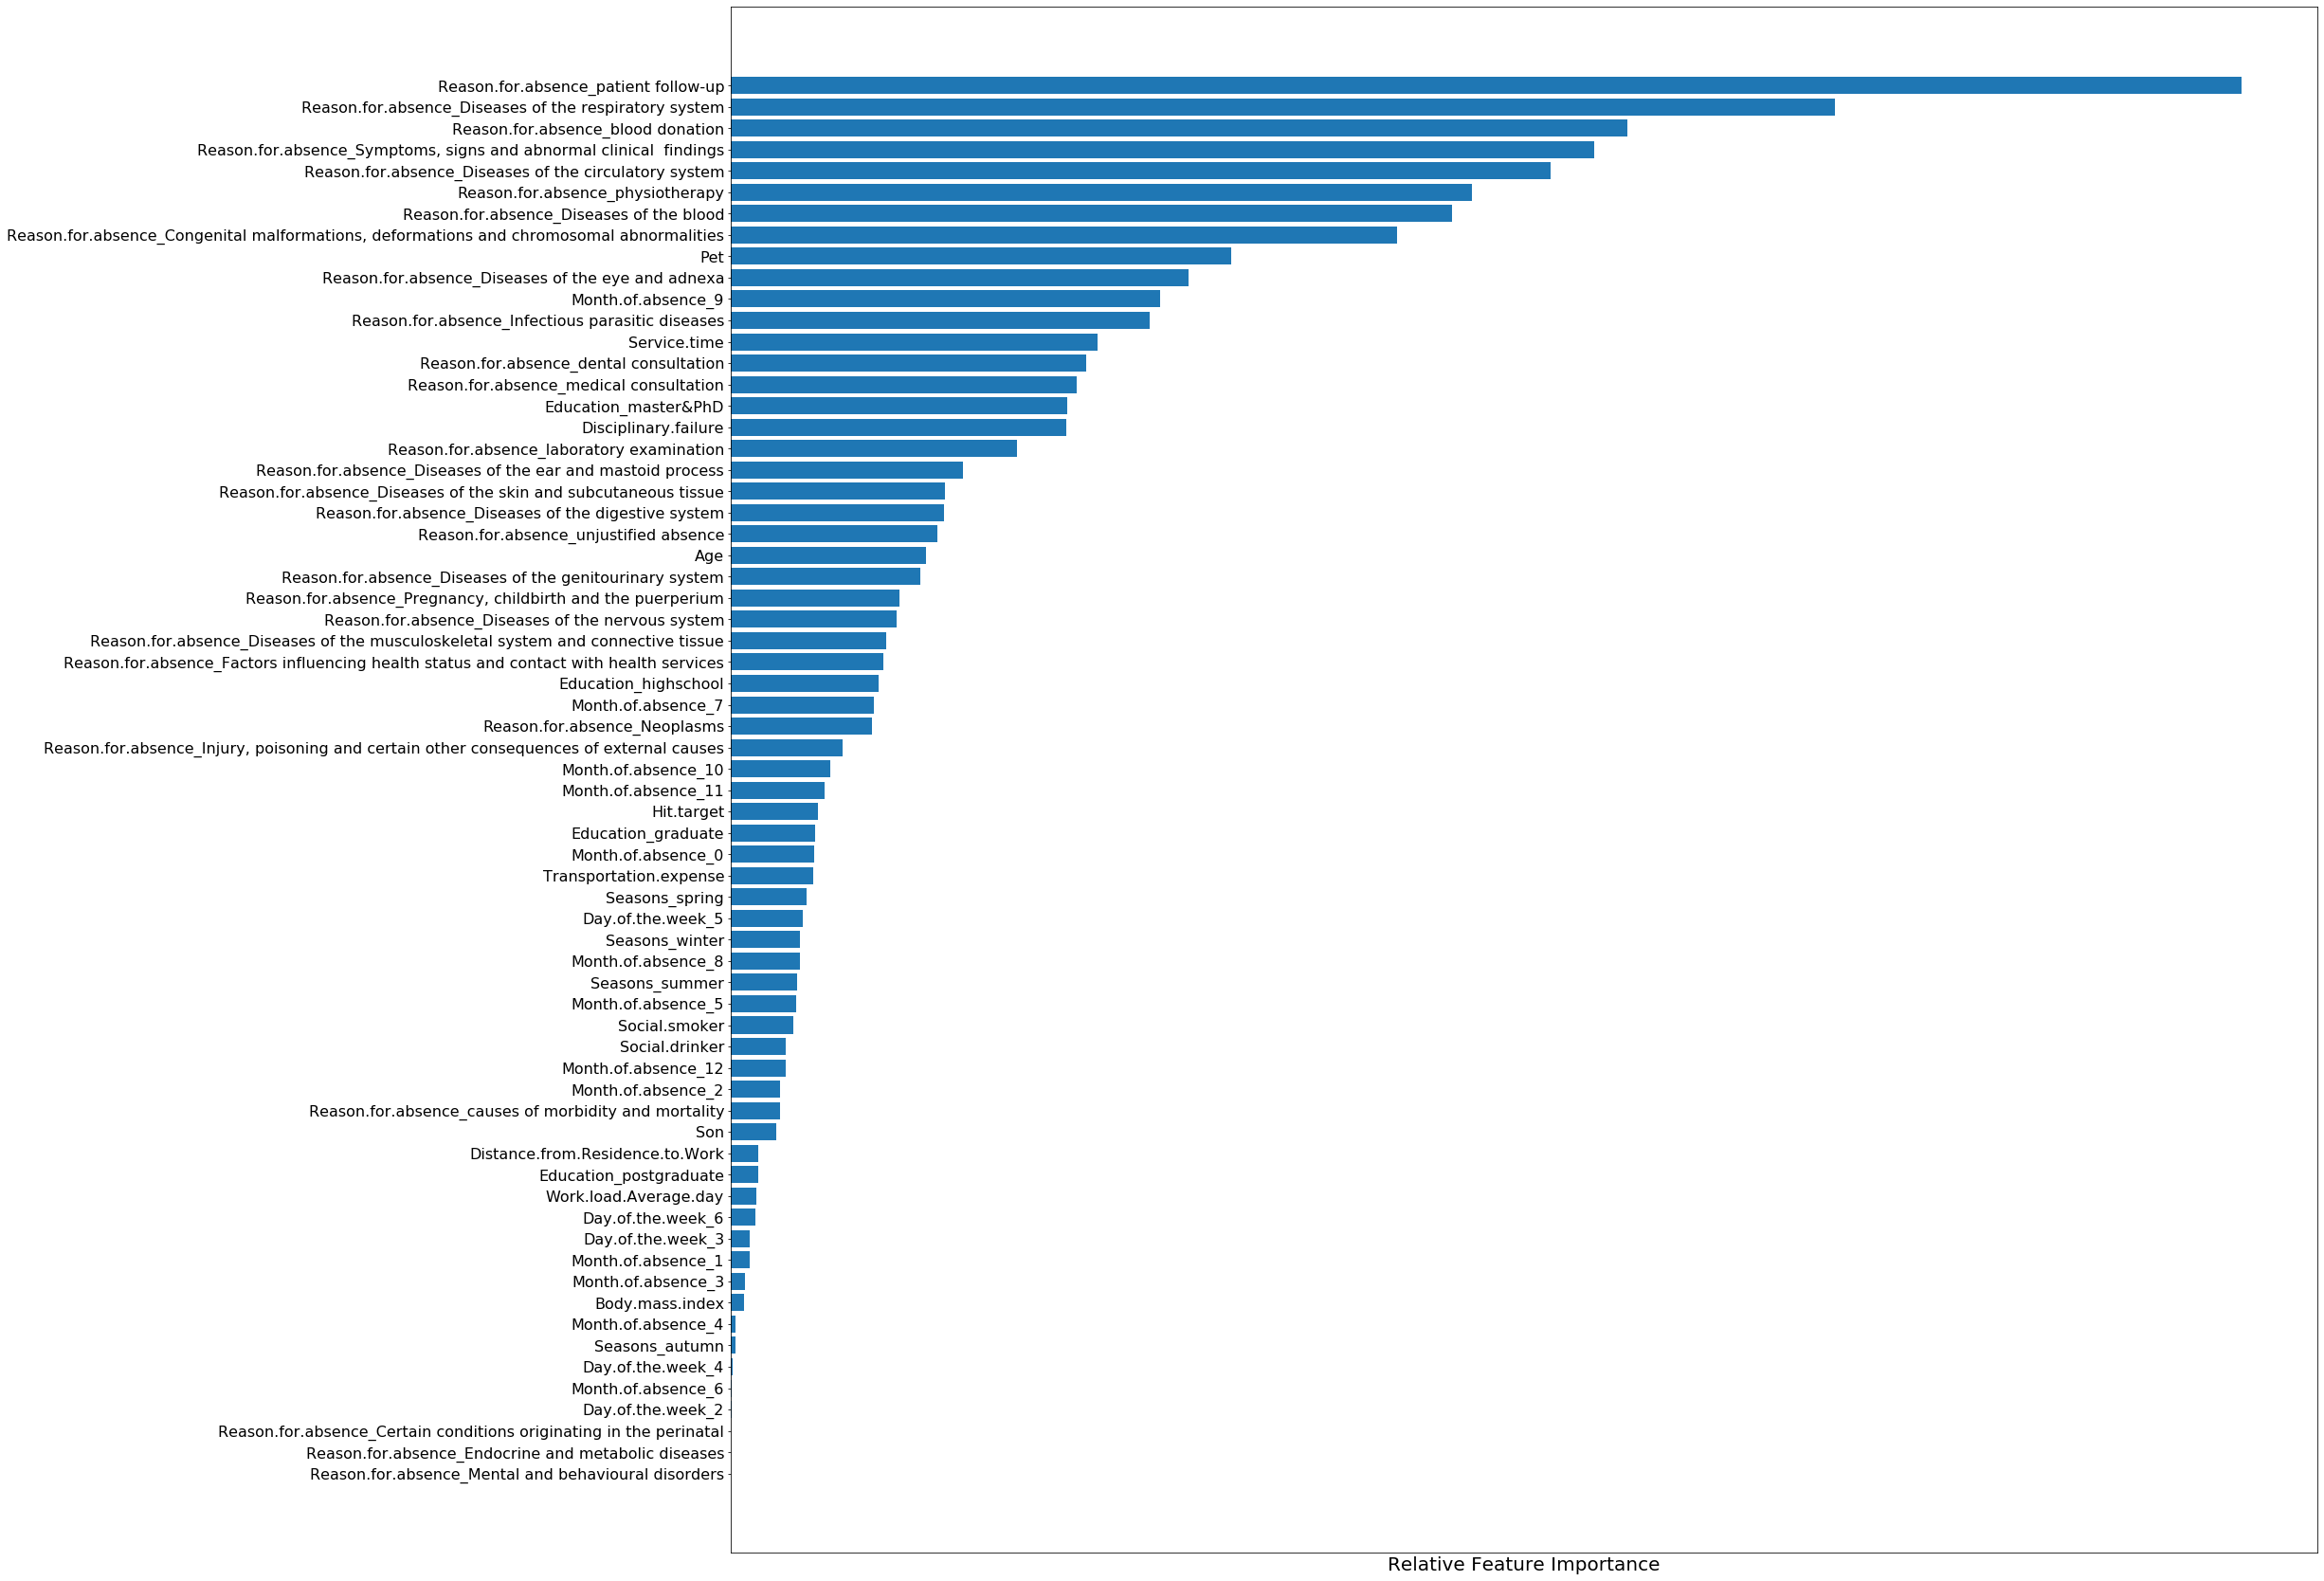

In [29]:
get_feature_importance(initial_lm_mod)

Accuracy = 0.7778


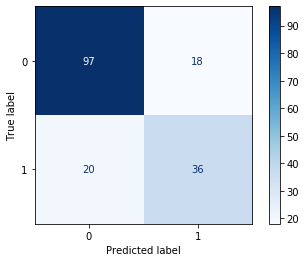

In [30]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,initial_lm_mod.predict(X_test))))
plot_confusion_matrix(initial_lm_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)


    We decided that this LR Accuracy will not be our threshold, we will use the 0.8078 of the baseline model done before since the TP in this linear model are 36 compared to 169 from our baseline. 
    Moreover, we can see that the TN in this case are 33% of the TN in our baseline model so it means that the previous model predicted that 310 employees are not gonna be absent which is true, while this model just predicts 97.


In [31]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])
results_df.loc[len(results_df)] = ['LR Baseline', score]
results_df

Approach  Accuracy
0  LR Baseline  0.807757

### Checking the Correlation

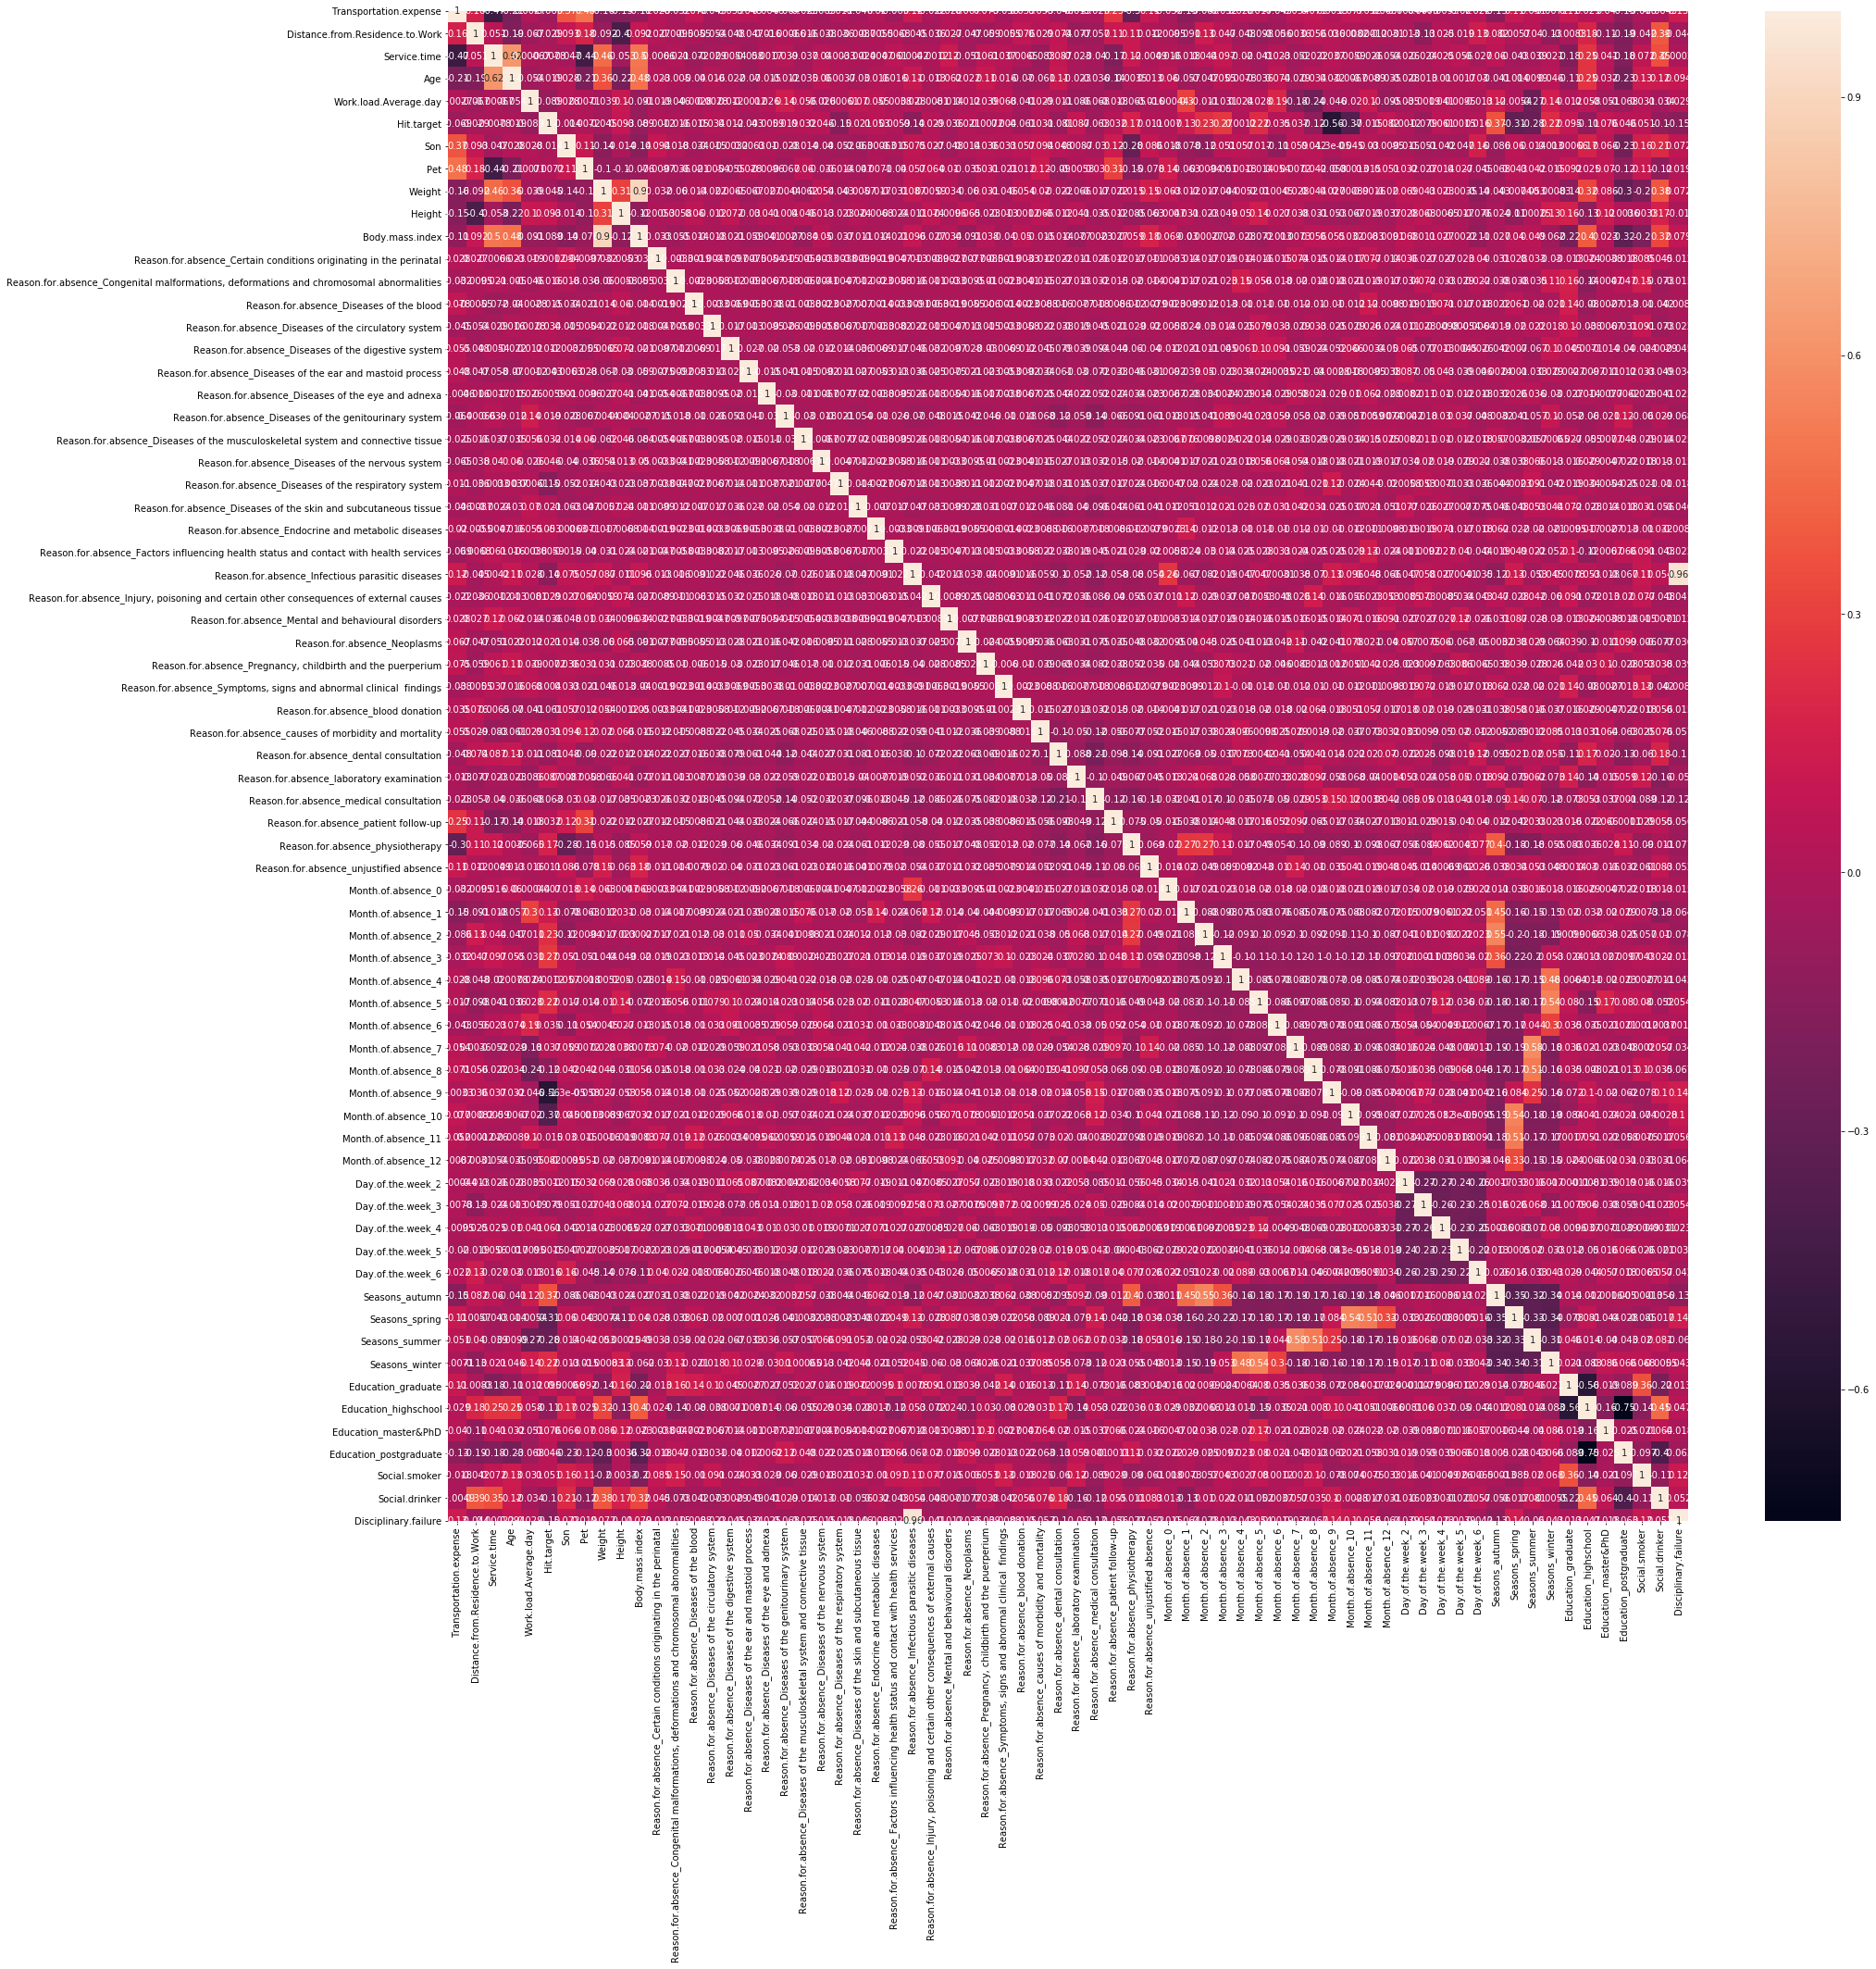

In [32]:
import seaborn as sns
dummified_dataset.corr()
plt.figure(figsize=(30,30))
sns.heatmap(dummified_dataset.corr(),annot=True)

## Feature Selection

Now we want to start selecting the optimal number of features to remove uninformative and misleading features.

### Filtering Methods



#### Chi-squared Selection
This method will help us measure the relationship between the features and the target feature and will make help us understand which features are 'representative enough'.

We will use this test to find the optimal number of features with the most logical accuracy. This number will then be used to filter out the features with less importance according to our analysis.
Most of the times the more features we use the higher accuracy. It is sometimes wrong to choose a high number of features since there is a possibility of overfitting.
We decided not to compute the chisquared value to filter out the features but manually select the features depending on accuracy as said before.

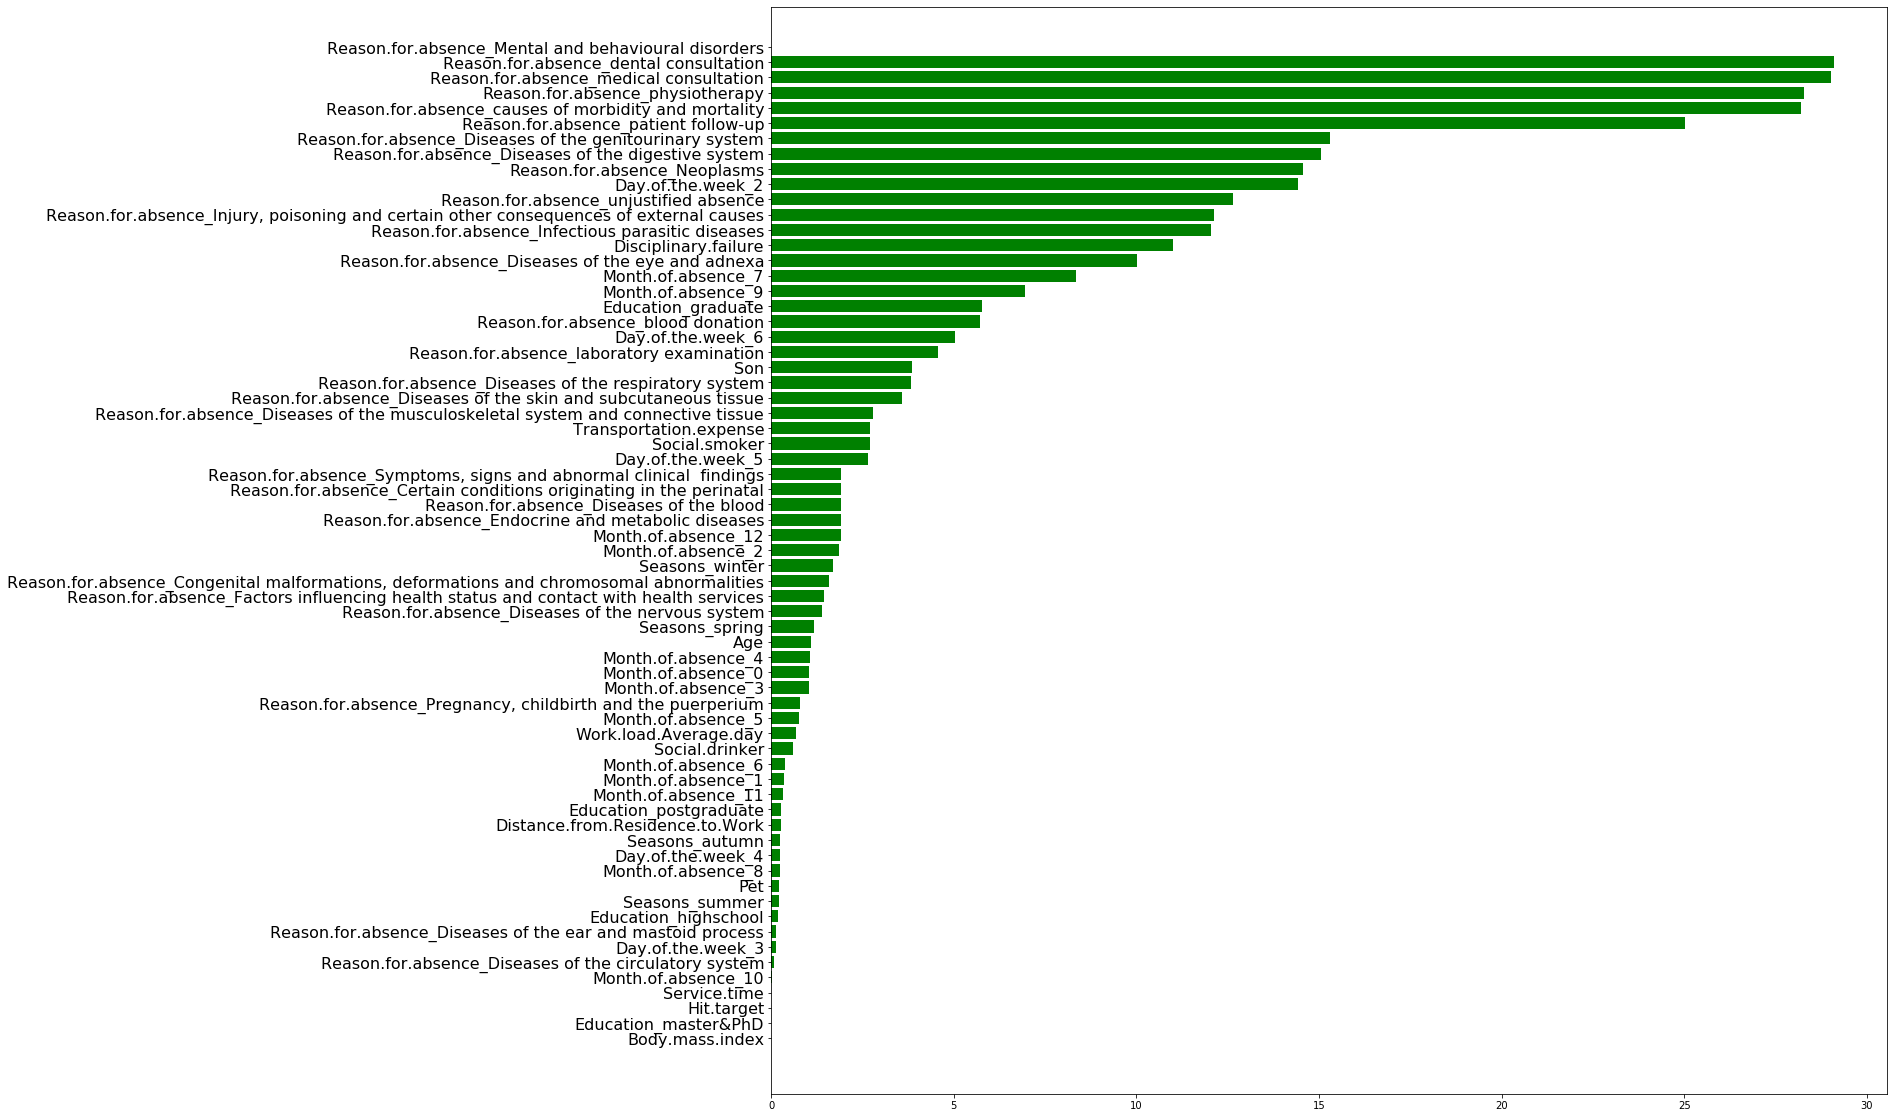

In [33]:
from sklearn.feature_selection import SelectKBest, chi2

chi2_selector = SelectKBest(score_func=chi2).fit(X,y)

# Get the indices sorted by most important to least important
indices = np.argsort(chi2_selector.scores_)[::-1]

chi2_features = []
for i in range(len(X.columns)):
    chi2_features.append(X.columns[indices[i]])

# Now plot
plt.figure(figsize=(20,20))
plt.yticks(rotation='horizontal',fontsize=16)
plt.barh(chi2_features, chi2_selector.scores_[indices[range(len(X.columns))]], color='g', align='center')
plt.gca().invert_yaxis()
plt.show()


In [34]:
for i in range(1,len(chi2_features)):
    print("Features used to train the model = {}".format(i))
    print("Accuracy = {0:.4f}".format(accuracy_score(y_test,linear_model.LogisticRegression(max_iter=1000, penalty='none').fit(X_train[chi2_features[:i]], y_train).predict(X_test[chi2_features[:i]]))))
    print()


Features used to train the model = 1
Accuracy = 0.6725

Features used to train the model = 2
Accuracy = 0.6725

Features used to train the model = 3
Accuracy = 0.6433

Features used to train the model = 4
Accuracy = 0.7485

Features used to train the model = 5
Accuracy = 0.7485

Features used to train the model = 6
Accuracy = 0.7485

Features used to train the model = 7
Accuracy = 0.7485

Features used to train the model = 8
Accuracy = 0.7485

Features used to train the model = 9
Accuracy = 0.7485

Features used to train the model = 10
Accuracy = 0.7602

Features used to train the model = 11
Accuracy = 0.7602

Features used to train the model = 12
Accuracy = 0.7836

Features used to train the model = 13
Accuracy = 0.7836

Features used to train the model = 14
Accuracy = 0.7836

Features used to train the model = 15
Accuracy = 0.8363

Features used to train the model = 16
Accuracy = 0.7778

Features used to train the model = 17
Accuracy = 0.8246

Features used to train the model = 18
Ac

    21 features is the optimal  umber of features to use to achieve a good model

In [35]:
chi2_features[:21]

['Reason.for.absence_Mental and behavioural disorders',
 'Reason.for.absence_dental consultation',
 'Reason.for.absence_medical consultation',
 'Reason.for.absence_physiotherapy',
 'Reason.for.absence_causes of morbidity and mortality',
 'Reason.for.absence_patient follow-up',
 'Reason.for.absence_Diseases of the genitourinary system',
 'Reason.for.absence_Diseases of the digestive system',
 'Reason.for.absence_Neoplasms',
 'Day.of.the.week_2',
 'Reason.for.absence_unjustified absence',
 'Reason.for.absence_Injury, poisoning and certain other consequences of external causes',
 'Reason.for.absence_Infectious parasitic diseases',
 'Disciplinary.failure',
 'Reason.for.absence_Diseases of the eye and adnexa',
 'Month.of.absence_7',
 'Month.of.absence_9',
 'Education_graduate',
 'Reason.for.absence_blood donation',
 'Day.of.the.week_6',
 'Reason.for.absence_laboratory examination']

    It seems that the top performance is achieved by selecting the top 11 features according ot IG, let's use them

In [36]:
chi2_initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
chi2_initial_lm_mod.fit(X_train[chi2_features[:21]], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

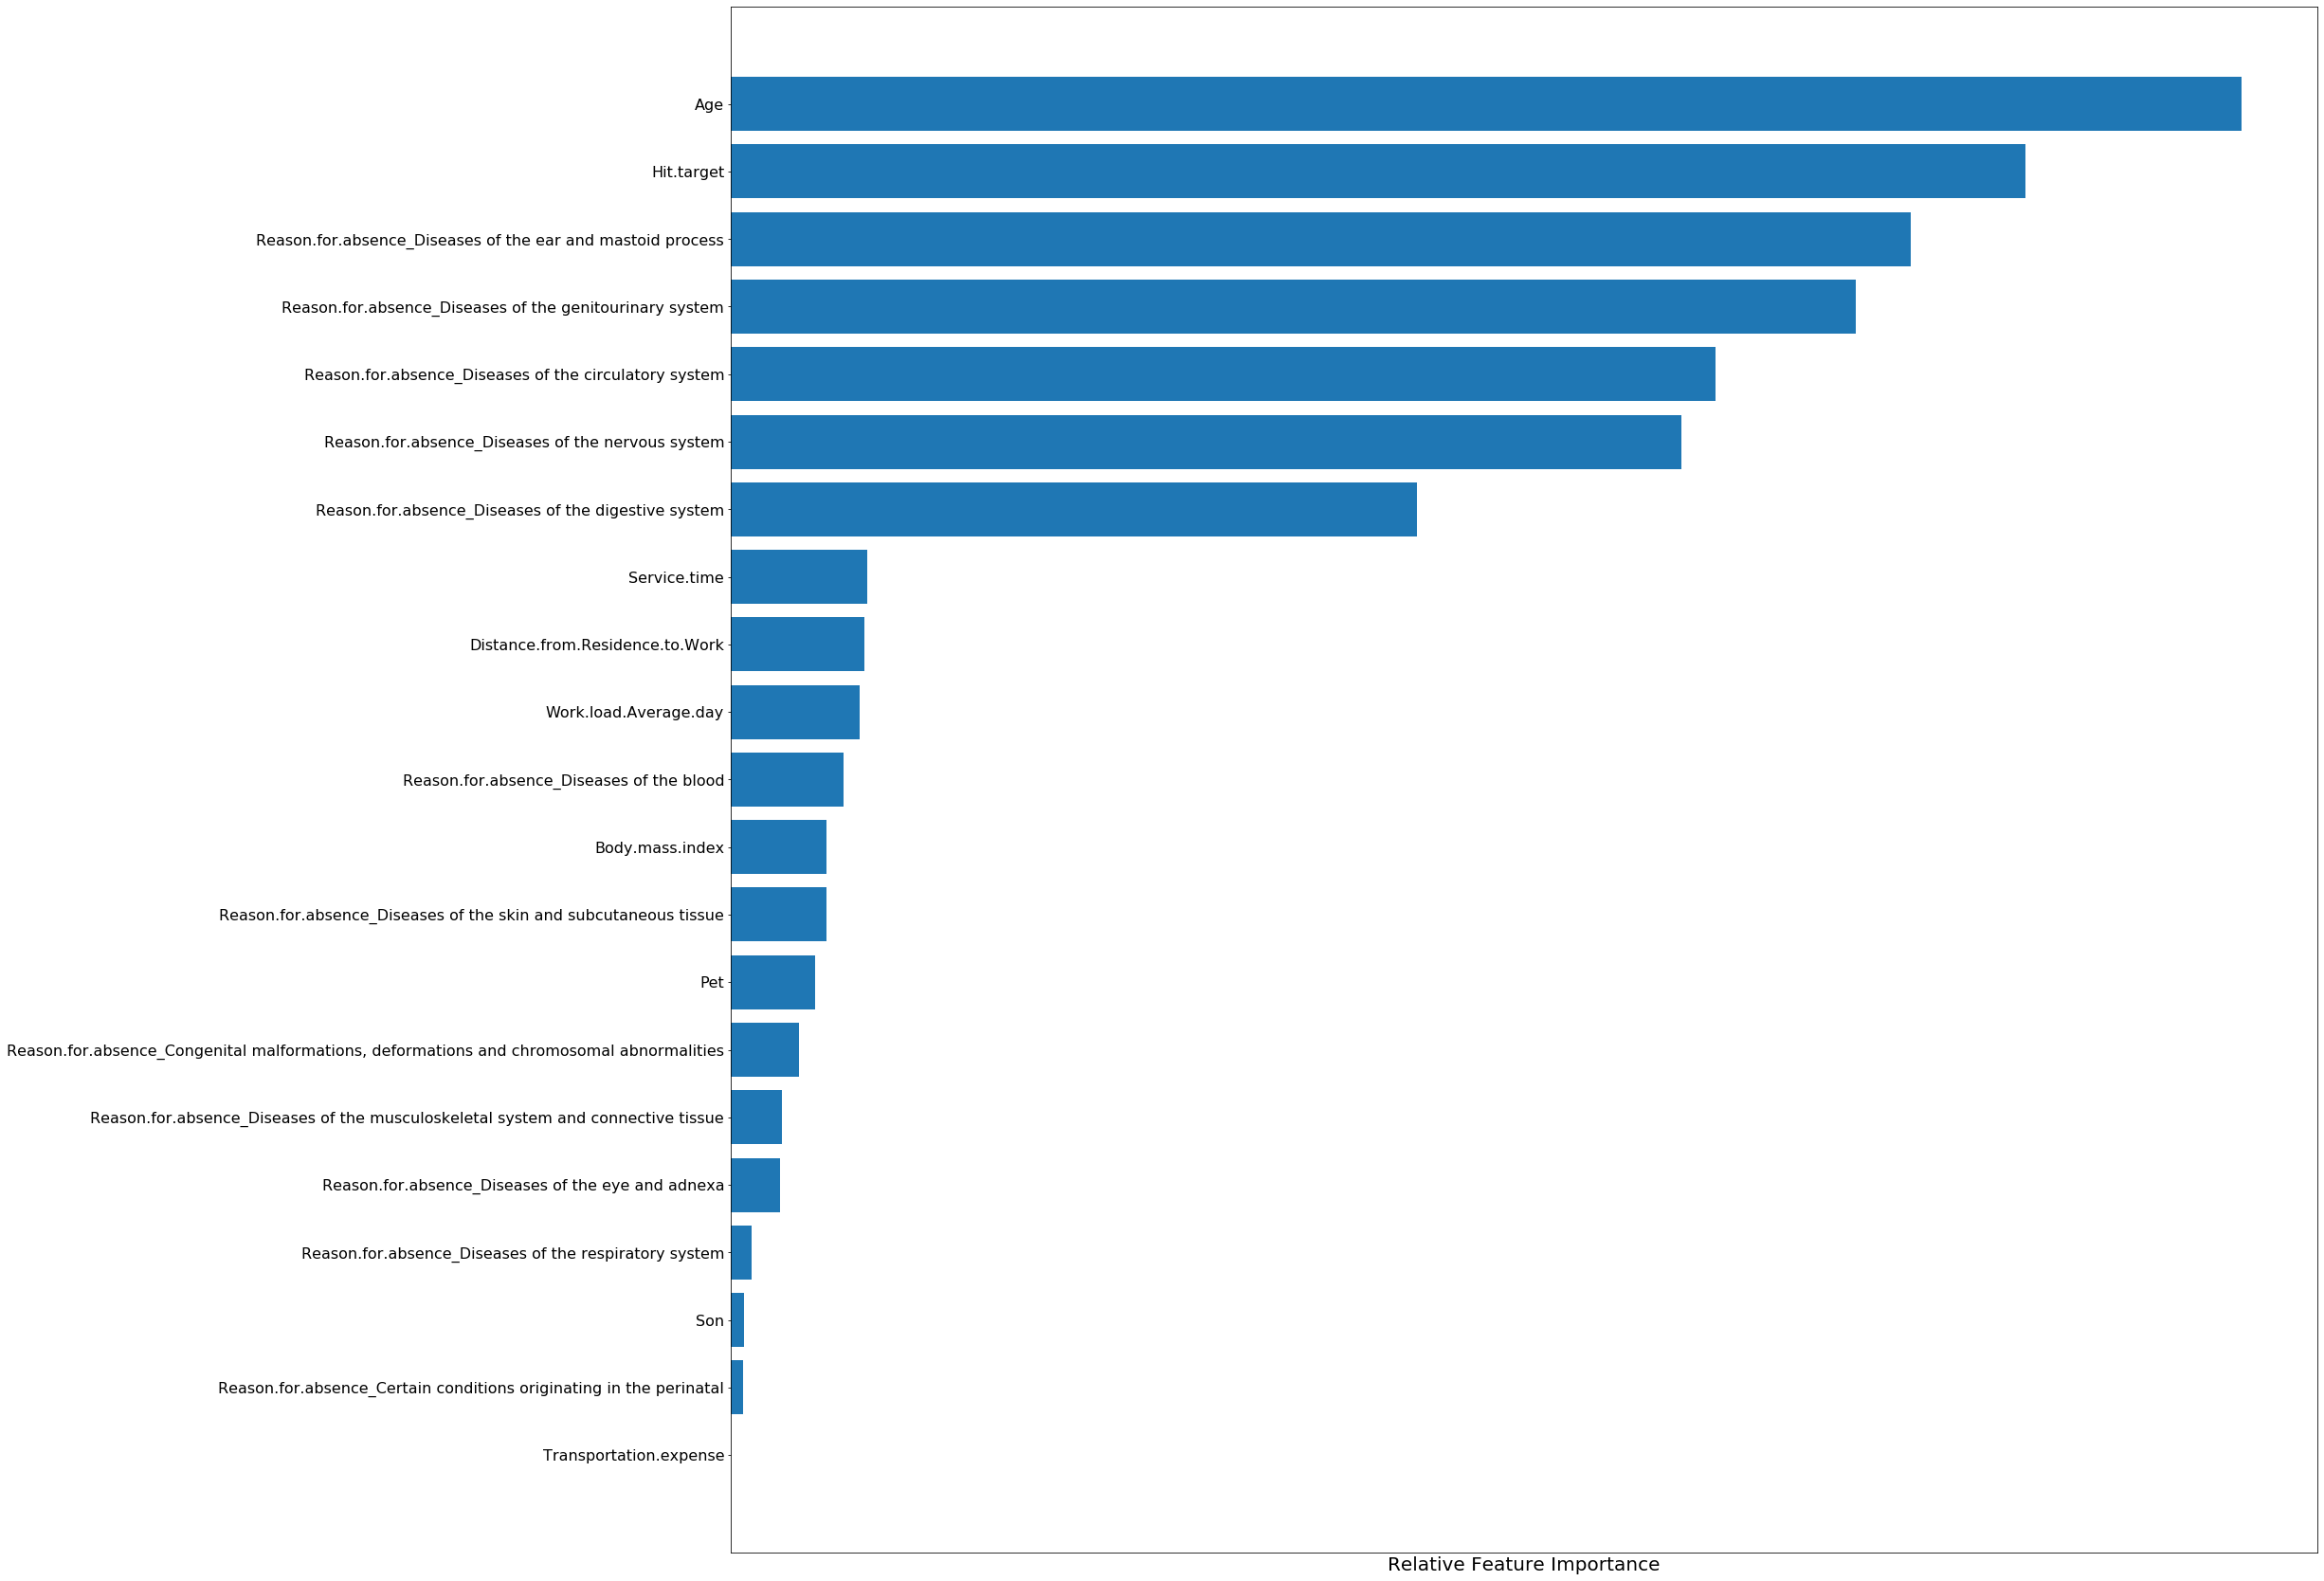

In [37]:
get_feature_importance(chi2_initial_lm_mod)

    After choosing the first 21 features of the chi-squared test, we want to test the CM


Accuracy = 0.8596


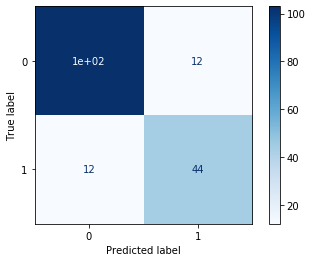

In [38]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,chi2_initial_lm_mod.predict(X_test[chi2_features[:21]]))))
plot_confusion_matrix(chi2_initial_lm_mod, X_test[chi2_features[:21]], y_test, y_test.unique(), cmap=plt.cm.Blues)

In [39]:
results_df.loc[len(results_df)] = ['LR ChiSquared Selection', accuracy_score(y_test,chi2_initial_lm_mod.predict(X_test[chi2_features[:21]]))]
results_df

Approach  Accuracy
0              LR Baseline  0.807757
1  LR ChiSquared Selection  0.859649

    It seems that the accuracy is much better. We can notice that our TN increased a lot while the FP and FN decreased.  Let's check the Information Gain


#### Information Gain Selection


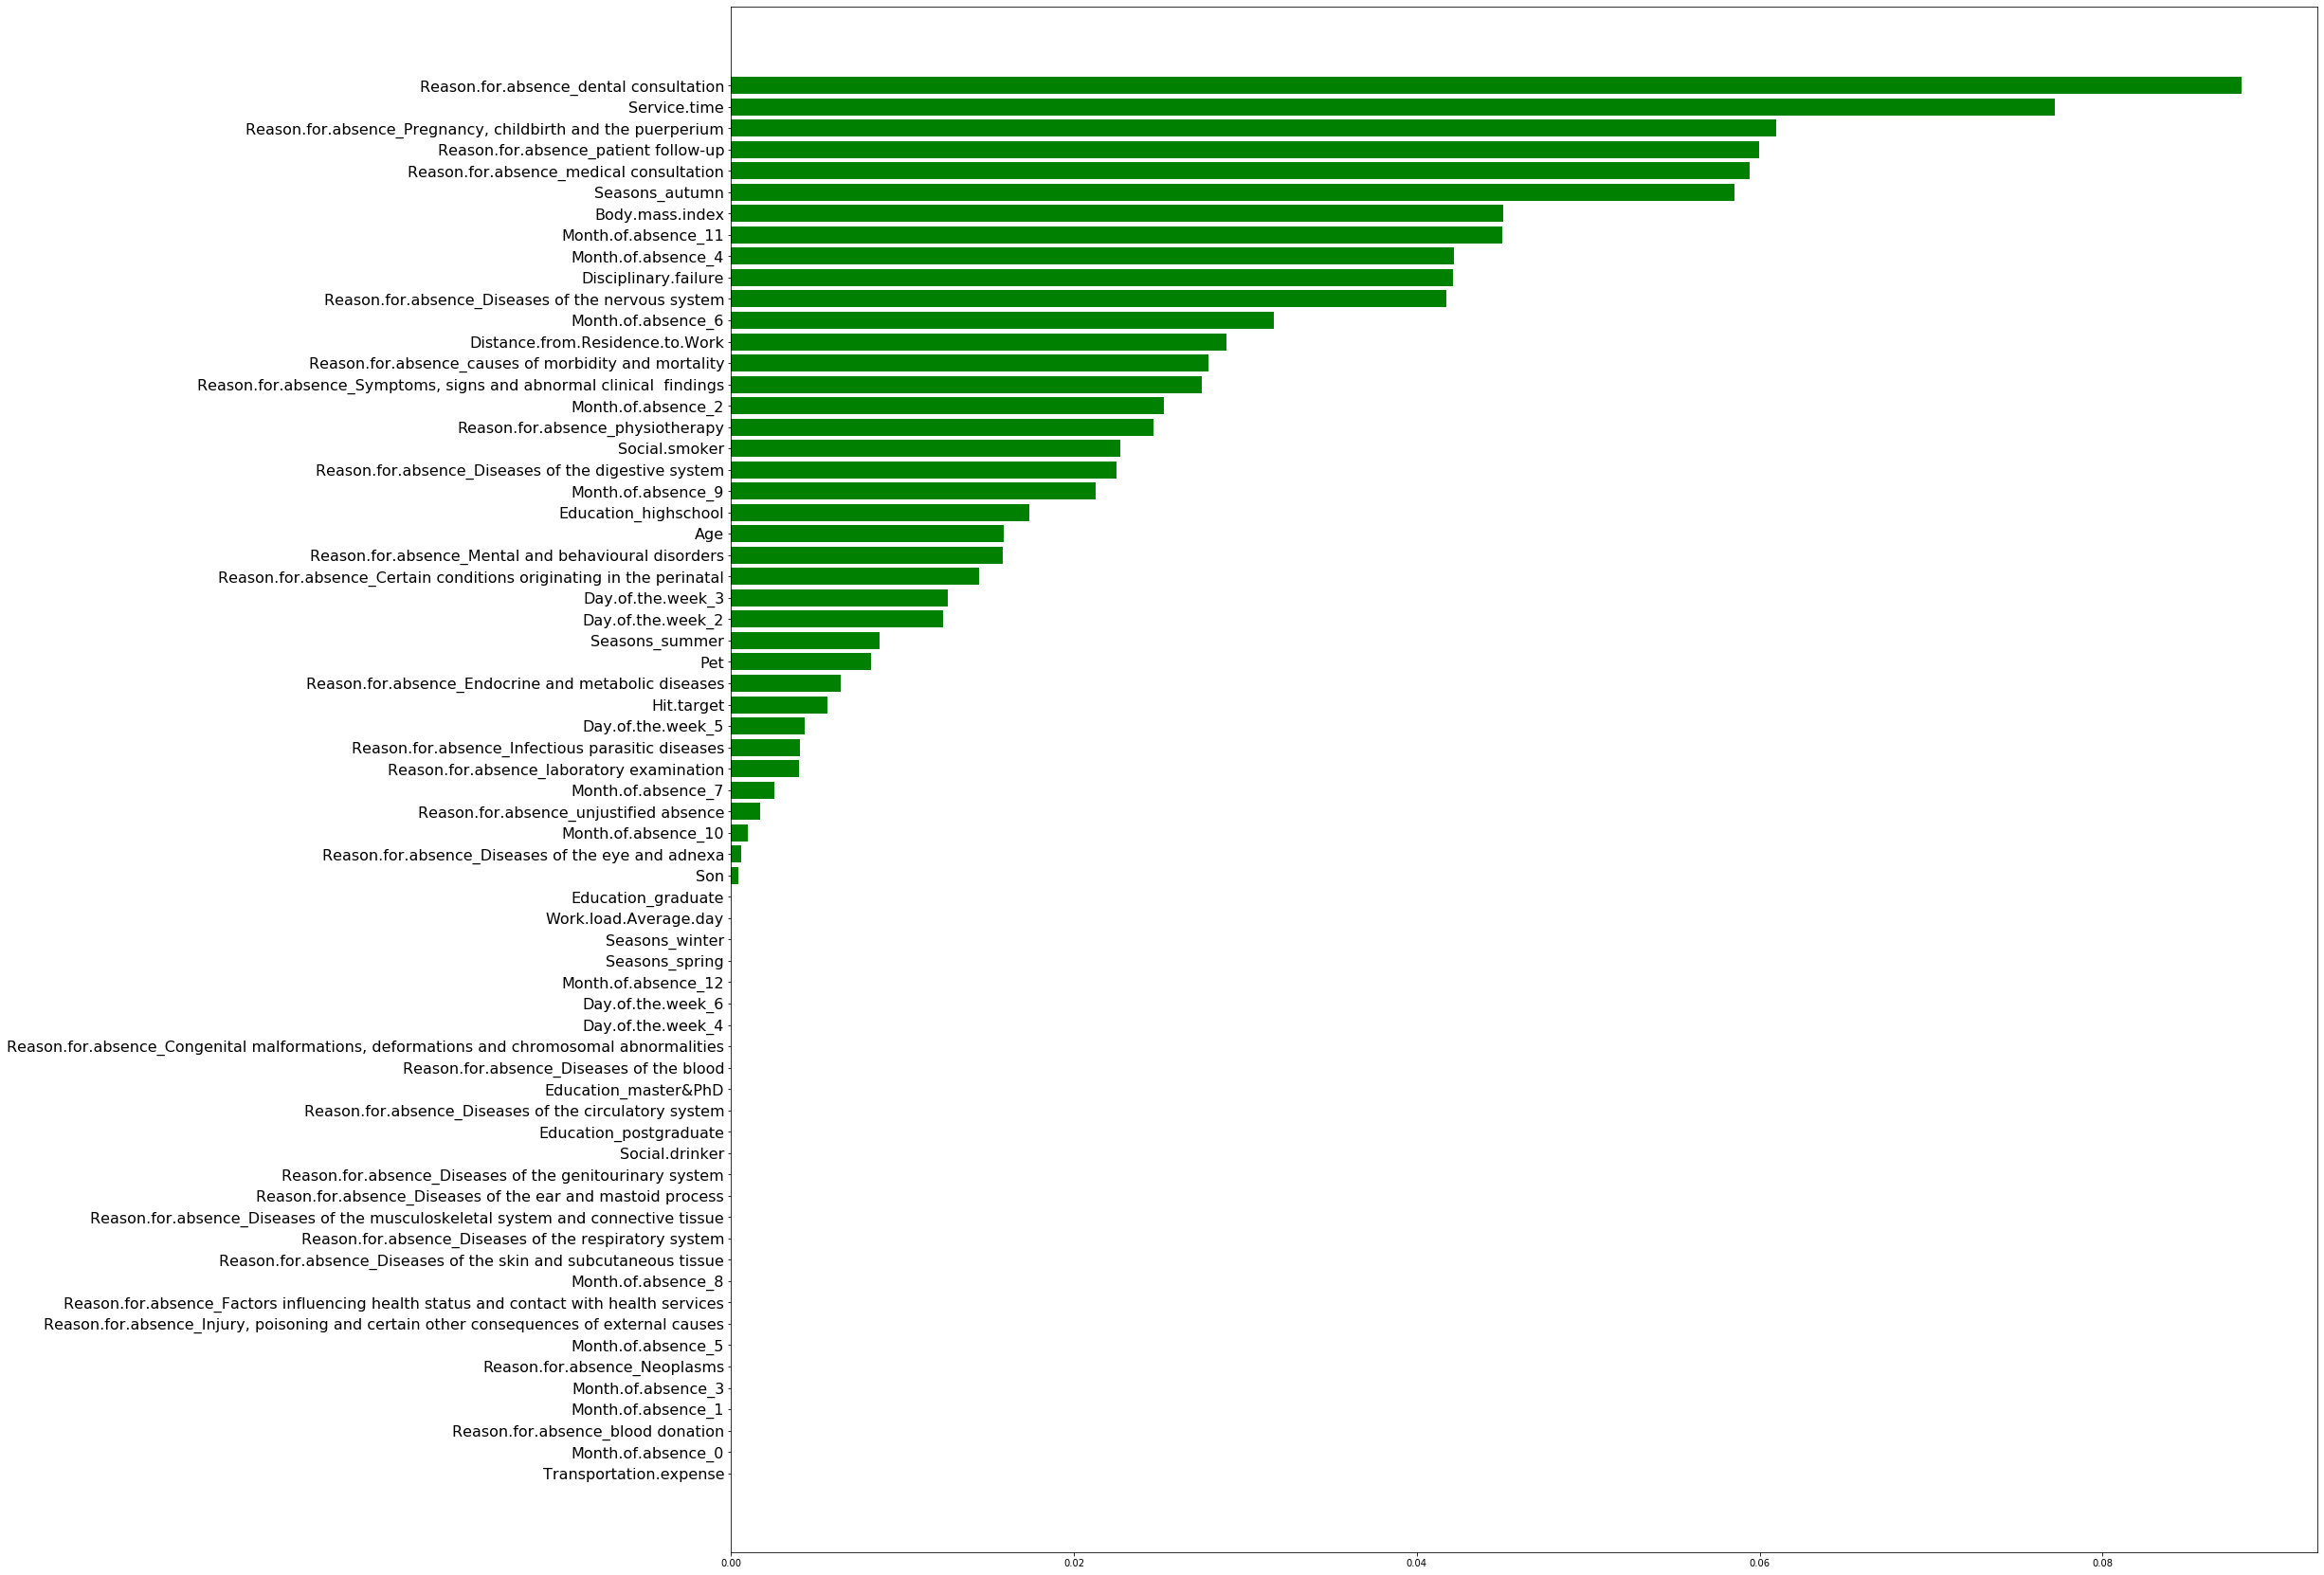

In [40]:
from sklearn.feature_selection import mutual_info_classif
np.random.seed(70)
ig_selector = SelectKBest(score_func=mutual_info_classif).fit(X,y)

# Get the indices sorted by most important to least important
indices = np.argsort(ig_selector.scores_)[::-1]

ig_features = []
for i in range(len(X.columns)):
    ig_features.append(X.columns[indices[i]])

# Now plot
plt.figure(figsize=(30,30))
plt.yticks(rotation='horizontal',fontsize=16)
plt.barh(ig_features, ig_selector.scores_[indices[range(len(X.columns))]], color='g', align='center')
plt.gca().invert_yaxis()
plt.show()

In [41]:
for i in range(1,len(ig_features)):
    print("Features used to train the model = {}".format(i))
    print("Accuracy = {0:.4f}".format(accuracy_score(y_test,linear_model.LogisticRegression(max_iter=1000, penalty='none').fit(X_train[ig_features[:i]], y_train).predict(X_test[ig_features[:i]]))))
    print()

Features used to train the model = 1
Accuracy = 0.6725

Features used to train the model = 2
Accuracy = 0.6725

Features used to train the model = 3
Accuracy = 0.6725

Features used to train the model = 4
Accuracy = 0.6901

Features used to train the model = 5
Accuracy = 0.6901

Features used to train the model = 6
Accuracy = 0.6725

Features used to train the model = 7
Accuracy = 0.6550

Features used to train the model = 8
Accuracy = 0.6667

Features used to train the model = 9
Accuracy = 0.7018

Features used to train the model = 10
Accuracy = 0.7427

Features used to train the model = 11
Accuracy = 0.7427

Features used to train the model = 12
Accuracy = 0.7544

Features used to train the model = 13
Accuracy = 0.7368

Features used to train the model = 14
Accuracy = 0.7427

Features used to train the model = 15
Accuracy = 0.7427

Features used to train the model = 16
Accuracy = 0.7427

Features used to train the model = 17
Accuracy = 0.7719

Features used to train the model = 18
Ac

    It seems that the highest accuracy is achieved by selecting more than 56 features. We decided to go with 20 features since the accuracy is 0.778, taking double the features will give us an accuracy of 0.80 which is a huge number of features.

In [42]:
ig_features[:20]

['Reason.for.absence_dental consultation',
 'Service.time',
 'Reason.for.absence_Pregnancy, childbirth and the puerperium',
 'Reason.for.absence_patient follow-up',
 'Reason.for.absence_medical consultation',
 'Seasons_autumn',
 'Body.mass.index',
 'Month.of.absence_11',
 'Month.of.absence_4',
 'Disciplinary.failure',
 'Reason.for.absence_Diseases of the nervous system',
 'Month.of.absence_6',
 'Distance.from.Residence.to.Work',
 'Reason.for.absence_causes of morbidity and mortality',
 'Reason.for.absence_Symptoms, signs and abnormal clinical  findings',
 'Month.of.absence_2',
 'Reason.for.absence_physiotherapy',
 'Social.smoker',
 'Reason.for.absence_Diseases of the digestive system',
 'Month.of.absence_9']

In [43]:
ig_initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
ig_initial_lm_mod.fit(X_train[ig_features[:20]], y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

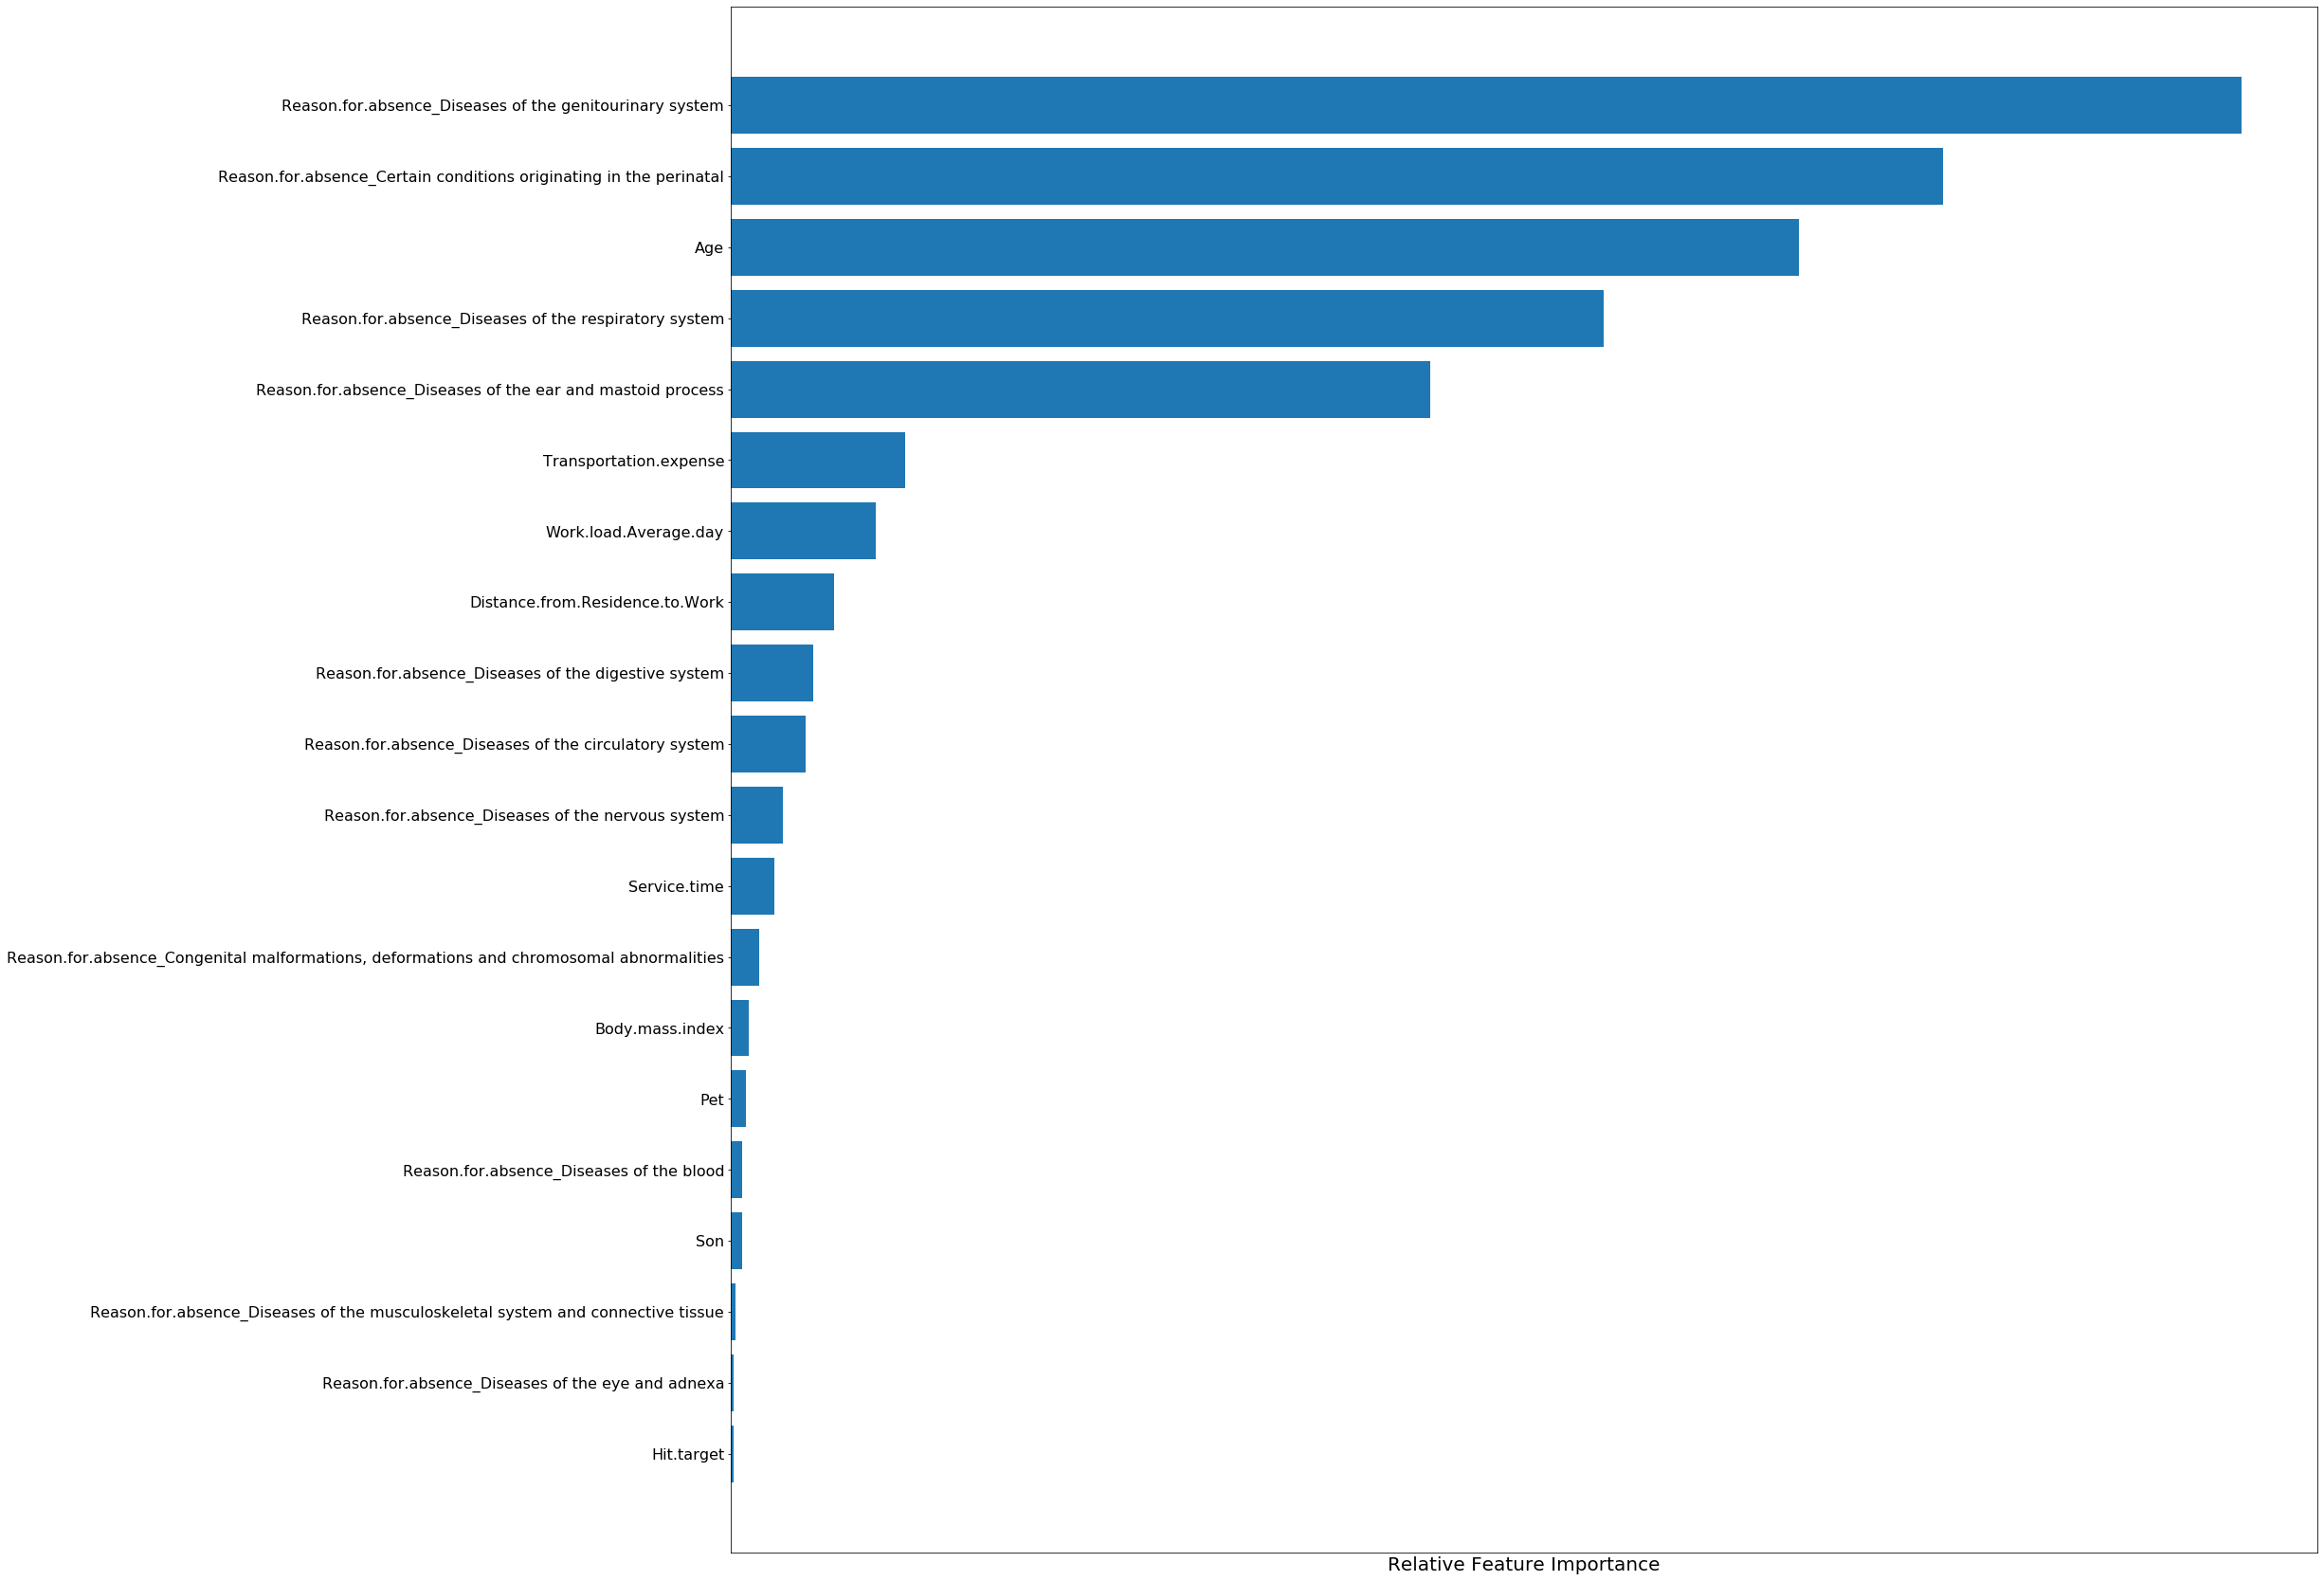

In [44]:
get_feature_importance(ig_initial_lm_mod)

Accuracy = 0.7778


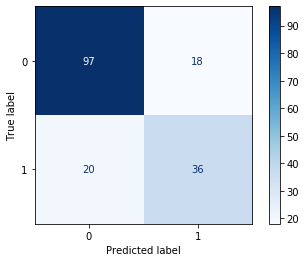

In [45]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ig_initial_lm_mod.predict(X_test[ig_features[:20]]))))
plot_confusion_matrix(ig_initial_lm_mod, X_test[ig_features[:20]], y_test, y_test.unique(), cmap=plt.cm.Blues)

In [46]:
results_df.loc[len(results_df)] = ['LR IG Selection', accuracy_score(y_test,ig_initial_lm_mod.predict(X_test[ig_features[:20]]))]
results_df

Approach  Accuracy
0              LR Baseline  0.807757
1  LR ChiSquared Selection  0.859649
2          LR IG Selection  0.777778

    Chi2-based performances is larger than IG-base, so in the following we will make use of this subset of features.

In [47]:
X_train = X_train[chi2_features[:21]]
X_test = X_test[chi2_features[:21]]

### Embedded

    Finally, we will apply embedded methods to create the final model.

#### Ridge Model


In [48]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
ridge_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

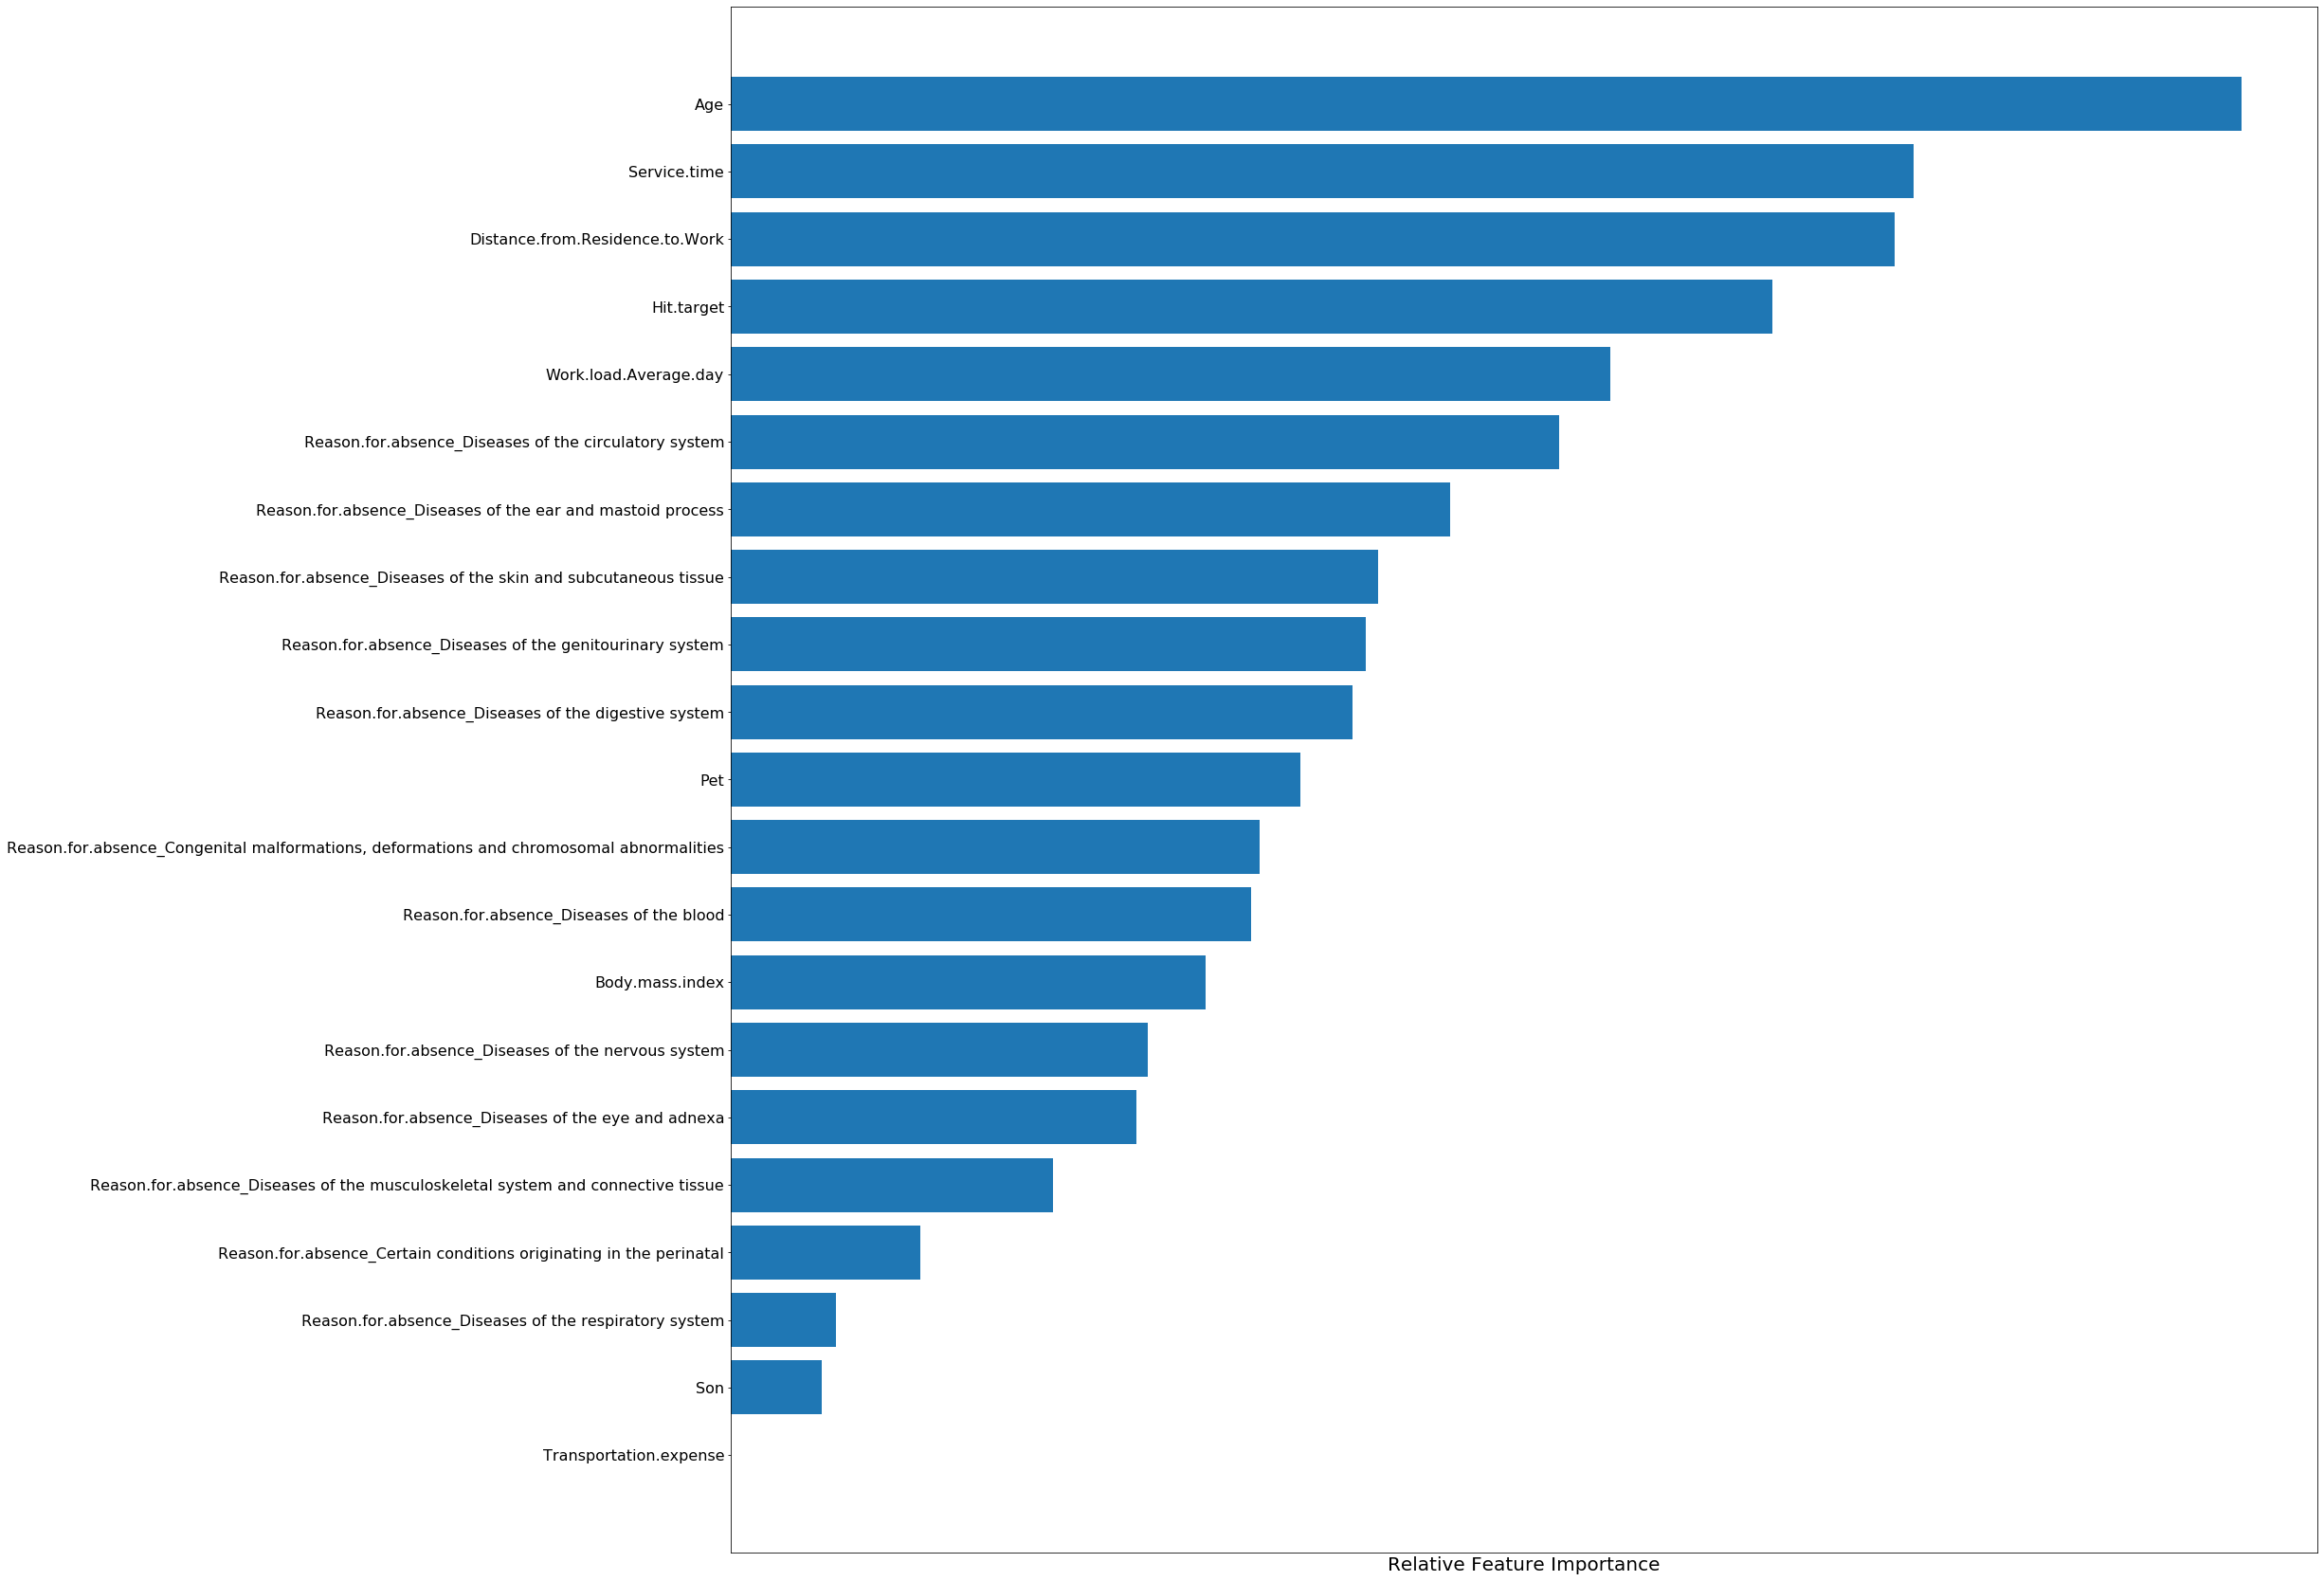

In [49]:
get_feature_importance(ridge_mod)

Accuracy = 0.8187


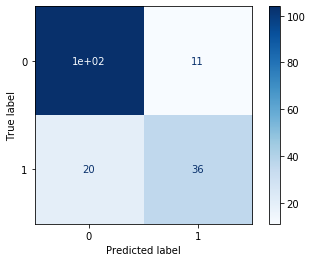

In [50]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod.predict(X_test))))
plot_confusion_matrix(ridge_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [51]:
results_df.loc[len(results_df)] = ['LR Ridge', accuracy_score(y_test,ridge_mod.predict(X_test))]
results_df

Approach  Accuracy
0              LR Baseline  0.807757
1  LR ChiSquared Selection  0.859649
2          LR IG Selection  0.777778
3                 LR Ridge  0.818713

    We can notice that there is a small improvement with respect to the unregularized models.
    Let's take a look at how the coefficient weights and accuracy scores change along the different alpha values.

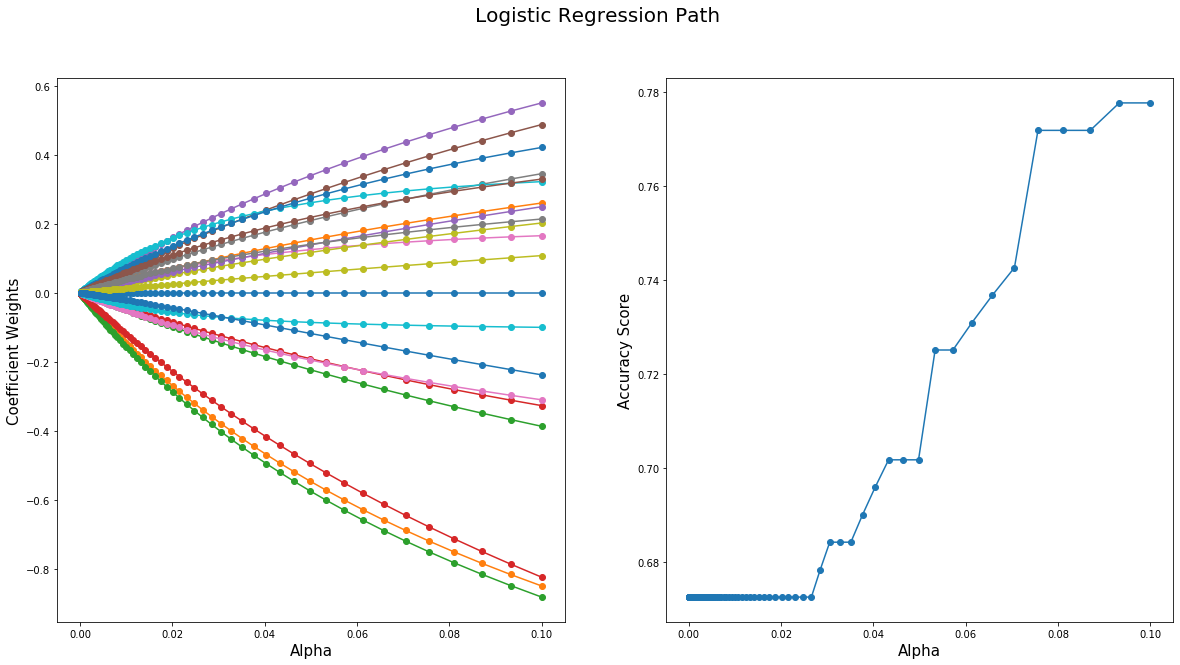

In [52]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    ridge_mod.set_params(C=a)
    ridge_mod.fit(X_train, y_train)
    coefs_.append(ridge_mod.coef_.ravel().copy())
    scores_.append(accuracy_score(y_test,ridge_mod.predict(X_test)))

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('Alpha', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('Alpha', fontsize = 15)
ax2.axis('tight')

plt.show()

    As we can see from the right figure, the maximum accuracy the alphas reach is around 0.78 which is not higher than our original Ridge Model.
    We will  anyway plot the CV to keep the results for future testing.

In [53]:
from sklearn.feature_selection import SelectFromModel
alphas = 10**np.linspace(-1,-4,150)

ridge_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2',Cs=alphas).fit(X_train, y_train)

Accuracy = 0.7719


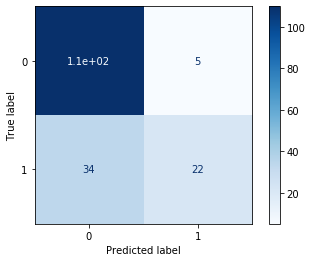

In [54]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,ridge_mod_cv.predict(X_test))))
plot_confusion_matrix(ridge_mod_cv, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [55]:
results_df.loc[len(results_df)] = ['LR CV Ridge', accuracy_score(y_test,ridge_mod_cv.predict(X_test))]
results_df

Approach  Accuracy
0              LR Baseline  0.807757
1  LR ChiSquared Selection  0.859649
2          LR IG Selection  0.777778
3                 LR Ridge  0.818713
4              LR CV Ridge  0.771930

#### Lasso

    Let's see if Lasso (which actually removes features by making their coefficients equal to 0) improves the unregularized model.


In [56]:
lasso_mod = linear_model.LogisticRegression(penalty='l1', solver='liblinear')
lasso_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

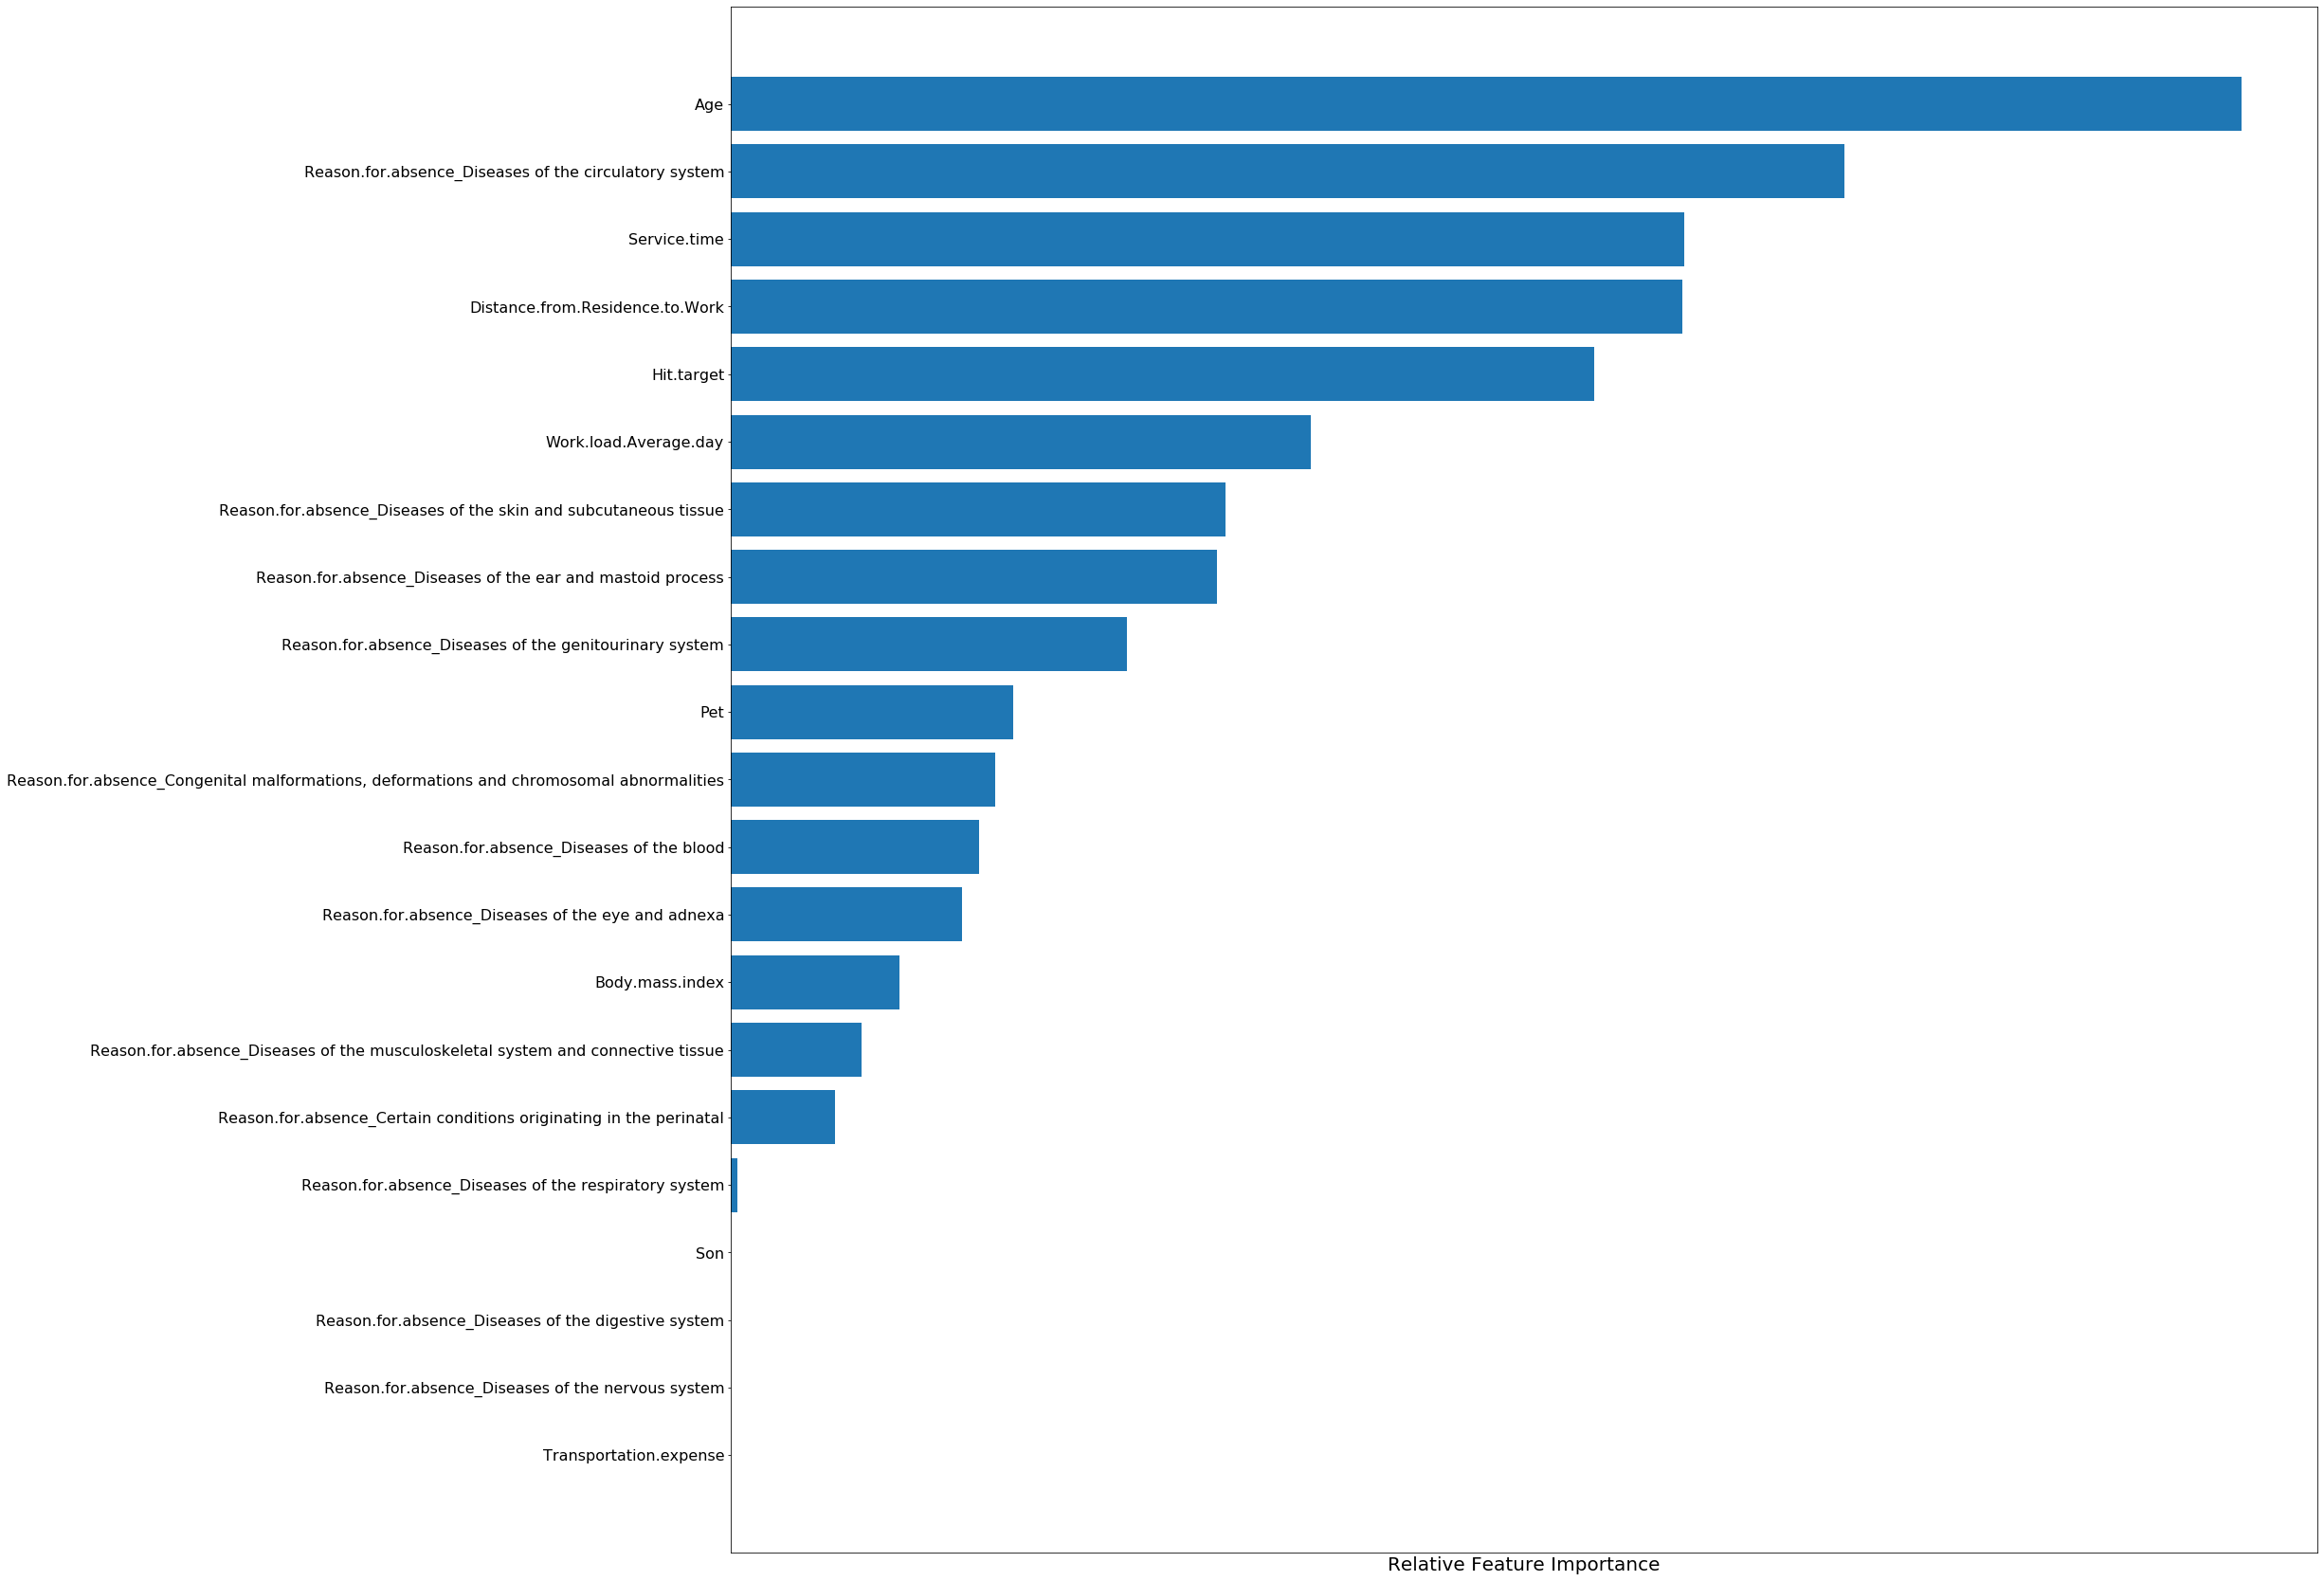

In [57]:
get_feature_importance(lasso_mod)

Accuracy = 0.8538


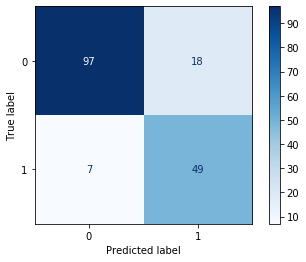

In [58]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,lasso_mod.predict(X_test))))
plot_confusion_matrix(lasso_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [59]:
results_df.loc[len(results_df)] = ['LR Lasso', accuracy_score(y_test,lasso_mod.predict(X_test))]
results_df

Approach  Accuracy
0              LR Baseline  0.807757
1  LR ChiSquared Selection  0.859649
2          LR IG Selection  0.777778
3                 LR Ridge  0.818713
4              LR CV Ridge  0.771930
5                 LR Lasso  0.853801

    The accuracy increased around 0.04 from Ridge to Lasso which means that putting the coefficients to zero improved the unregularized model

    We will run a LR on the lasso LM below using penalty l2 and not l1 since we will have a higher and more logical accuracy.

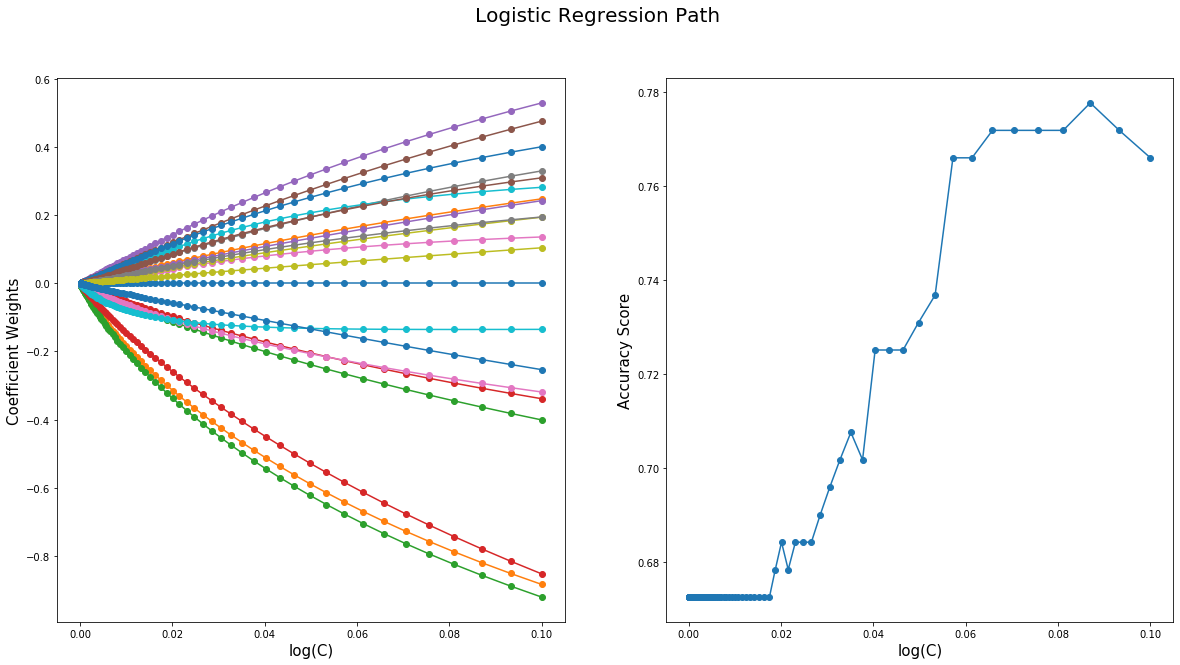

In [60]:
lasso_mod = linear_model.LogisticRegression(penalty='l2',solver='liblinear')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    lasso_mod.set_params(C=a)
    lasso_mod.fit(X_train, y_train)
    coefs_.append(lasso_mod.coef_.ravel().copy())
    scores_.append(accuracy_score(y_test,lasso_mod.predict(X_test)))

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('log(C)', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('log(C)', fontsize = 15)
ax2.axis('tight')

plt.show()

    Running the LM with a penalty of l1 we get an accuracy of 0.67 which is steady when we increase our Log(C). 

In [61]:
from sklearn.feature_selection import SelectFromModel

lasso_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2',solver='liblinear',Cs=alphas).fit(X_train, y_train)

Accuracy = 0.7661


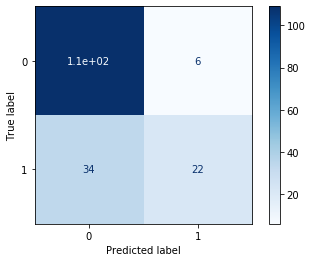

In [62]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,lasso_mod_cv.predict(X_test))))
plot_confusion_matrix(lasso_mod_cv, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [63]:
results_df.loc[len(results_df)] = ['LR CV Lasso', accuracy_score(y_test,lasso_mod_cv.predict(X_test))]
results_df

Approach  Accuracy
0              LR Baseline  0.807757
1  LR ChiSquared Selection  0.859649
2          LR IG Selection  0.777778
3                 LR Ridge  0.818713
4              LR CV Ridge  0.771930
5                 LR Lasso  0.853801
6              LR CV Lasso  0.766082

    The performance of CV of the Lasso and Ridge is nearly close but their LM is much different.
    Since Lasso is actually performing Feature Selection (i.e., it nullifies/removes unimportant features) you can apply the trained model to transform your dataset to keep only the features selected by Lasso

In [64]:
model = SelectFromModel(lasso_mod_cv, prefit=True)
X_new = model.transform(X_train)
X_test_new = model.transform(X_test)
print("Original Number of Features = {} --> Number of features selected by Lasso = {}".format(X_train.shape[1], X_new.shape[1]))

Original Number of Features = 21 --> Number of features selected by Lasso = 7


    Lasso is removing 14 features since we did remove many features in the ChiSquared selection. It explains why the results of both Lasso and Ridge are so similar.
    We can notice from below that oru new trained model has a higher accuracy.

Accuracy = 0.7953


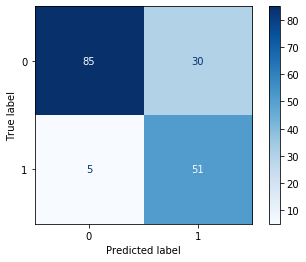

In [65]:
reduced_lasso_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l1', solver='liblinear')
reduced_lasso_mod.fit(X_new, y_train)
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,reduced_lasso_mod.predict(X_test_new))))
plot_confusion_matrix(reduced_lasso_mod, X_test_new, y_test, y_test.unique(), cmap=plt.cm.Blues)

In [66]:
results_df.loc[len(results_df)] = ['LR Reduced Lasso', accuracy_score(y_test,reduced_lasso_mod.predict(X_test_new))]
results_df

Approach  Accuracy
0              LR Baseline  0.807757
1  LR ChiSquared Selection  0.859649
2          LR IG Selection  0.777778
3                 LR Ridge  0.818713
4              LR CV Ridge  0.771930
5                 LR Lasso  0.853801
6              LR CV Lasso  0.766082
7         LR Reduced Lasso  0.795322

### Testing the Algorithms
    To choose the optimal accuracy to predit

In [ ]:
X = X[chi2_features[:21]]

### Decision Tree

In [117]:
from sklearn.tree import DecisionTreeClassifier

Decision_tree = DecisionTreeClassifier(random_state=42)
Decision_tree.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [121]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score
predictions = Decision_tree.predict(dummified_dataset_test[chi2_features[:21]])
Decision_tree.score(X,y)

0.862934362934363

### XGBoost

In [69]:
! pip install xgboost
import xgboost

In [116]:
xgb_tree = xgboost.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_tree.fit(X, y)
predictions = xgb_tree.predict(dummified_dataset_test[chi2_features[:21]])
xgb_tree.score(X,y)


0.833976833976834

#### Random Forest

In [128]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, max_depth=10)
rf_model = rf.fit(X,y)
rf_model.predict(dummified_dataset_test[chi2_features[:21]])
rf_model.score(X,y)

0.859073359073359

Since our Decision Tree model got the highest accuracy of **0.863**, we will use it to predict future Absenteeism for the HR Department

In [129]:
#rfm = RandomForestClassifier(n_estimators=1000)
#dtm = DecisionTreeClassifier(n_estimators = 1000)

TypeError: __init__() got an unexpected keyword argument 'n_estimators'

In [130]:
final_model = Decision_tree.fit(X, y)
# Test prediction
final_pred = final_model.predict(dummified_dataset_test[chi2_features[:21]])

In [132]:
predictions = pd.DataFrame({'ID':test['ID'], 'Absenteeism.time.in.hours':final_pred})
predictions.to_csv("predictions.csv", index=False)